# Présentation du projet : 


## Problématique de la ville de Seattle

Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.
Votre mission

## Mission
Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :

* Réaliser une courte analyse exploratoire.
* Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

## Conseils
Avant de quitter la salle de brief, Douglas, le project lead, vous donne quelques pistes, et erreurs à éviter :

* L’objectif est de te passer des relevés de consommation annuels (attention à la fuite de données), mais rien ne t'interdit d’en déduire des variables plus simples (nature et proportions des sources d’énergie utilisées). 

* Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

* Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithme de ML à l’aide d’une validation croisée.



# Ressources : 

## Les données et leur description :

Adresse des données : https://www.kaggle.com/city-of-seattle/sea-building-energy-benchmarking#2015-building-energy-benchmarking.csv

Site source, ville de Seattle : https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m

Site de visualisation des données : http://www.seattle.gov/energybenchmarkingmap/#seattle/2019?layer=energy_star_score&sort=energy_star_score&order=desc&lat=47.61&lng=-122.33&zoom=14

Description des variables globales : 

* data 2015 : https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m
* data 2016 : https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy
* description plus détaillée (sur 2018) : https://www.splitgraph.com/seattle-gov/2018-building-energy-benchmarking-7rac-kyay

Description de variables particulières :
* Energy star score : https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results
* 2010 Census tract : https://www.census.gov/geographies/reference-maps/2010/geo/2010-census-tract-maps.html

## Sur les méthodes stat :


## Sur les outils de programmation : 


# Présentation du notebook : 

##TODO : écrire une petite intro


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "/home/clairegayral/Documents/openclassroom/data/P3/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P3/"

## my .py : 
from P3_preprocess import *
import missing_values_treatment
import duplicates
import univariate_analysis
import multivariate_analysis

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import KNNImputer
from sklearn import linear_model


# 1. Lecture des données : 
J'ai commencé par ouvrir les deux table avec la bibliothèque pandas : 

In [2]:
df_2015 = pd.read_csv(data_path+"2015-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)
df_2016 = pd.read_csv(data_path+"2016-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)

print("In 2015 data :", df_2015.shape[0],
      " buildings and ", df_2015.shape[1],"variables")
print("Total NaNs = ", df_2015.isna().sum().sum(), 
      "(that is ",np.round(100*df_2015.isna().sum().sum()/(
        df_2015.shape[0]*df_2015.shape[1]),2), "%)")
print(" ")
print("In 2016 data :", df_2016.shape[0],
      " buildings and ", df_2016.shape[1],"variables")
print("Total NaNs = ", df_2016.isna().sum().sum(), 
      "(that is ",np.round(100*df_2016.isna().sum().sum()/(
        df_2016.shape[0]*df_2015.shape[1]),2), "%)")

In 2015 data : 3340  buildings and  47 variables
Total NaNs =  26512 (that is  16.89 %)
 
In 2016 data : 3376  buildings and  46 variables
Total NaNs =  19952 (that is  12.57 %)


## Identification des variables communes 

Les deux tables de données n'ont pas les mêmes variables. Certaines variables sont communes. D'autres ont l'air de correspondre d'une table à l'autre mais n'ont pas la même nomenclature. 
C'est le cas de :
* ```Zip Codes``` dans 2015 et ```ZipCode``` dans 2016
* ```Comment``` dans 2015 et ```Comments``` dans 2016

Il y a aussi les variables de localisation, présentes sous forme de pseudo-dictionnaire dans la variable ```Location``` des données 2015, et dans les colonnes ```Address```, ```City```, ```Latitude```, ```Longitude``` et ```State``` des données 2016. Ces variables ne me semblent pas pertinentes pour la suite de l'étude, car il y a une variable catégorielle ```Neighborhood```qui me semble être un proxi largement suffisant, et beaucoup plus simple à manier. 

De la même manière, j'ai choisi de supprimer la varible ```2010 Census Tracts``` de la table de 2015, car c'est une variable de localisation, et elle est très creuse (93.3% de valeurs manquantes)

In [3]:
### rename similar columns in 2015 as in 2016 data
df_2015 = df_2015.rename(columns={"Zip Codes":"ZipCode2015",
                                 "Comment":"Comments"})
### Location column split to extract longitude and latitude
print(df_2015["Location"][0].split(","))

### remove non-pertinent columns : 
df_2015 = df_2015.drop(["Location", '2010 Census Tracts', 'City Council Districts'], axis=1)
df_2016 = df_2016.drop(['Address', 'City', 'Latitude', 'Longitude', 'State'],axis=1)

["{'latitude': '47.61219025'", " 'longitude': '-122.33799744'", ' \'human_address\': \'{"address": "405 OLIVE WAY"', ' "city": "SEATTLE"', ' "state": "WA"', ' "zip": "98101"}\'}']


In [4]:
tmp2015 = np.sort(df_2015.columns)
tmp2016 = np.sort(df_2016.columns)

tmp2015 = tmp2015[[var not in df_2016.columns.values for var in tmp2015]]
tmp2016 = tmp2016[[var not in df_2015.columns.values for var in tmp2016]]
tmp_both = df_2015.columns.intersection(df_2016.columns)
## affichage que dans 2015 
print("Les variables qui ne sont que dans les données 2015 : ")
for var in tmp2015 : print("\t",var, ": ", 
                           np.round(100*df_2015[var].isna().sum() / df_2015.shape[0],1), "% NaNs" )
## affichage que dans 2016 
print("\nLes variables qui ne sont que dans les données 2016 : ")
for var in tmp2016 : print("\t",var, ": ", 
                           100*np.round(df_2016[var].isna().sum() / df_2016.shape[0],1), "% NaNs" )
## affichage variables communes :
print("\nLes variables communes aux données 2015 et 2016 : ")
for var in tmp_both : 
    percent_nans =100* (df_2015[var].isna().sum() / df_2015.shape[0] 
                    + df_2016[var].isna().sum() / df_2016.shape[0])/2
    print("\t",var,": ", np.round(percent_nans,1), "% NaNs" )


Les variables qui ne sont que dans les données 2015 : 
	 GHGEmissions(MetricTonsCO2e) :  0.3 % NaNs
	 GHGEmissionsIntensity(kgCO2e/ft2) :  0.3 % NaNs
	 OtherFuelUse(kBtu) :  0.3 % NaNs
	 SPD Beats :  0.1 % NaNs
	 Seattle Police Department Micro Community Policing Plan Areas :  0.1 % NaNs
	 ZipCode2015 :  0.0 % NaNs

Les variables qui ne sont que dans les données 2016 : 
	 GHGEmissionsIntensity :  0.0 % NaNs
	 TotalGHGEmissions :  0.0 % NaNs
	 ZipCode :  0.0 % NaNs

Les variables communes aux données 2015 et 2016 : 
	 OSEBuildingID :  0.0 % NaNs
	 DataYear :  0.0 % NaNs
	 BuildingType :  0.0 % NaNs
	 PrimaryPropertyType :  0.0 % NaNs
	 PropertyName :  0.0 % NaNs
	 TaxParcelIdentificationNumber :  0.0 % NaNs
	 CouncilDistrictCode :  0.0 % NaNs
	 Neighborhood :  0.0 % NaNs
	 YearBuilt :  0.0 % NaNs
	 NumberofBuildings :  0.1 % NaNs
	 NumberofFloors :  0.1 % NaNs
	 PropertyGFATotal :  0.0 % NaNs
	 PropertyGFAParking :  0.0 % NaNs
	 PropertyGFABuilding(s) :  0.0 % NaNs
	 ListOfAllPropertyUs

D'autres variables ont l'air d'avoir un lien fort ```GHGEmissions(MetricTonsCO2e)``` et ```TotalGHGEmissions```. Néanmoins, sachant que le taux CO2 est une des deux variables à prédire, il me paraît nécessaire de ne pas les fusionner avant d'avoir vérifier qu'il n'y avait pas un biais entre les deux. D'après [ce site](https://www.epa.gov/ghgemissions/overview-greenhouse-gases) les émissions de CO2 représentent 80% des émissions de gaz à effet de serre (GHG pour "Green House Gases" en anglais). Vérifions s'il est possible de corriger le biais d'avoir une mesure sur tous les GHG sur la table 2016 :


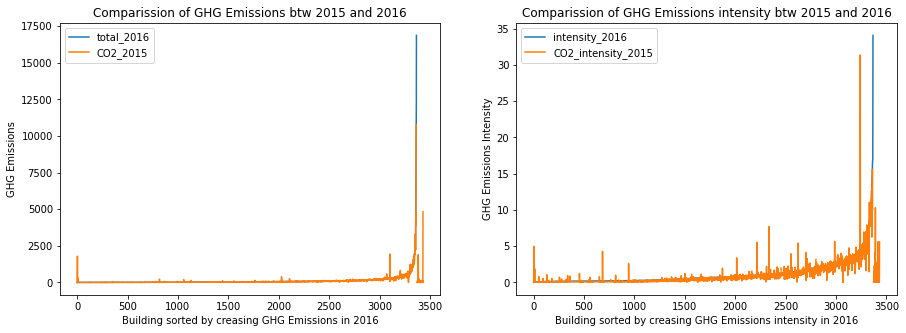

In [5]:
GHG_emissions = pd.merge(
    df_2016[["OSEBuildingID","TotalGHGEmissions","GHGEmissionsIntensity"]], 
    df_2015[["OSEBuildingID", "GHGEmissions(MetricTonsCO2e)","GHGEmissionsIntensity(kgCO2e/ft2)"]], 
    on ="OSEBuildingID" , how = 'outer', suffixes=('', '_2015')).copy()
GHG_emissions = GHG_emissions.rename(columns={"TotalGHGEmissions": "total_2016", 
                                              "GHGEmissionsIntensity":"intensity_2016",
                                              "GHGEmissions(MetricTonsCO2e)":"CO2_2015" ,
                                              "GHGEmissionsIntensity(kgCO2e/ft2)":"CO2_intensity_2015"})
fig = plt.figure(figsize=(15,5))
## plot to compare GHG emission and CO2 emission :
ax = fig.add_subplot(1,2,1)
GHG_emissions = GHG_emissions.sort_values(by = "total_2016", axis = 0 )
ax.plot(range(GHG_emissions.shape[0]), GHG_emissions[["total_2016","CO2_2015"]] )
ax.set_title("Comparission of GHG Emissions btw 2015 and 2016")
ax.set_xlabel("Building sorted by creasing GHG Emissions in 2016")
ax.set_ylabel("GHG Emissions")
ax.legend(["total_2016","CO2_2015"])
## plot to compare intensity of emission
GHG_emissions = GHG_emissions.sort_values(by = "intensity_2016", axis = 0)
ax = fig.add_subplot(1,2,2)
ax.plot(range(GHG_emissions.shape[0]), GHG_emissions[["intensity_2016","CO2_intensity_2015"]] )
ax.set_title("Comparission of GHG Emissions intensity btw 2015 and 2016")
ax.set_xlabel("Building sorted by creasing GHG Emissions intensity in 2016")
ax.set_ylabel("GHG Emissions Intensity")
ax.legend(["intensity_2016","CO2_intensity_2015"])
plt.show()

Il ne semble pas y avoir de biais entre ces deux mesures : je choisis donc de les fusionner, sous le nom commun de respectivement ```CO2_emissions``` et ```CO2_emissions_intensity``` : 

In [6]:
df_2016 = df_2016.rename(columns={"TotalGHGEmissions": "CO2_emissions", 
                                  "GHGEmissionsIntensity":"CO2_emissions_intensity"})
df_2015 = df_2015.rename(columns={"GHGEmissions(MetricTonsCO2e)":"CO2_emissions" ,
                                  "GHGEmissionsIntensity(kgCO2e/ft2)":"CO2_emissions_intensity"})
tmp2015 = np.sort(df_2015.columns)
tmp2016 = np.sort(df_2016.columns)
tmp2015 = tmp2015[[var not in df_2016.columns.values for var in tmp2015]]
tmp2016 = tmp2016[[var not in df_2015.columns.values for var in tmp2016]]
## affichage que dans 2015 
print("Les variables qui ne sont que dans les données 2015 : ")
for var in tmp2015 : print("\t",var, ": ", 
                           np.round(100*df_2015[var].isna().sum() / df_2015.shape[0],1), "% NaNs" )
print(df_2015[tmp2015].describe())

## affichage que dans 2016 
print("\nLes variables qui ne sont que dans les données 2016 : ")
for var in tmp2016 : print("\t",var,  ": ", 
                           np.round(100*df_2016[var].isna().sum() / df_2016.shape[0],1), "% NaNs" )
# print(df_2016[tmp2016].head())

Les variables qui ne sont que dans les données 2015 : 
	 OtherFuelUse(kBtu) :  0.3 % NaNs
	 SPD Beats :  0.1 % NaNs
	 Seattle Police Department Micro Community Policing Plan Areas :  0.1 % NaNs
	 ZipCode2015 :  0.0 % NaNs
       OtherFuelUse(kBtu)    SPD Beats  \
count        3.330000e+03  3338.000000   
mean         7.142301e+03    24.825644   
std          1.962790e+05    15.006287   
min          0.000000e+00     1.000000   
25%          0.000000e+00    10.000000   
50%          0.000000e+00    26.000000   
75%          0.000000e+00    38.000000   
max          8.269669e+06    51.000000   

       Seattle Police Department Micro Community Policing Plan Areas  \
count                                        3338.000000               
mean                                           32.380168               
std                                            19.907567               
min                                             1.000000               
25%                                    

J'ai supprimé ces variables qui n'apparaissent que dans une des deux tables : 

In [7]:
# df_2015 = df_2015.drop(tmp2015, axis = 1)
# df_2016 = df_2016.drop(tmp2016, axis = 1)

## Age des bâtiments 
Il me parait plus pertinent de traiter la variable ```YearBuilt``` comme variable quantitative, plutôt que comme variable catégorielle. Pour cela, je déduis 2015 (resp. 2016) à la colonne ```YearBuilt``` pour la remplacer par la nouvelle colonne ```age_of_building```

In [8]:
df_2015.at[:,"age_of_building"] = df_2015["DataYear"] - df_2015["YearBuilt"]
df_2016.at[:,"age_of_building"] = df_2016["DataYear"] - df_2016["YearBuilt"]

df_2015 = df_2015.drop(["YearBuilt","DataYear"], axis = 1)
df_2016 = df_2016.drop(["YearBuilt","DataYear"], axis = 1)

## Changement de type pour ne pas créer de nouvelles valeurs catégorielles :
La variable "CouncilDistrictCode" est une variable catégorielle, ainsi que ZipCode2015 (vu après)

In [9]:
df_2015[["CouncilDistrictCode", "ZipCode2015"]] = df_2015[["CouncilDistrictCode", "ZipCode2015"]].astype("category")
df_2016[["CouncilDistrictCode"]] = df_2016[["CouncilDistrictCode"]].astype("category")

## Data merge : 

I decided to merge the 2016 and 2015 dataframes, taking the mean value if the building is in both.

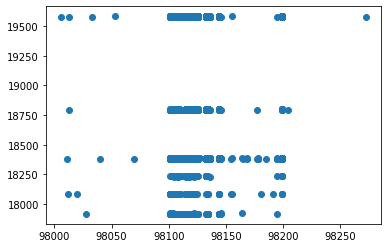

In [10]:
plt.scatter(df_2016.loc[df_2015.index,"ZipCode"],df_2015["ZipCode2015"])

In [11]:
data = pd.merge(df_2016, df_2015, on ="OSEBuildingID" ,
               how = 'outer', suffixes=('', '_2015'))

def my_agg_by_mean(colname):
    if colname[-5:] == "_2015":
        res = data.loc[:,[colname[:-5],colname]]
        data.at[:,colname[:-5]] = res.mean(axis=1)
        data.drop(colname, axis=1, inplace=True)
    return(data)        
    
def my_agg_filling_missing(colname) :
    if colname[-5:] == "_2015":
        res = data.loc[:,[colname[:-5],colname]]
        data.at[:,colname[:-5]] = res[colname[:-5]].fillna(res[colname])
        data.drop(colname, axis=1, inplace=True)
    return(data)
    
float_var = data.loc[:,data.dtypes==float].columns.values
int_var = data.loc[:,data.dtypes==int].columns.values
all_num_var = np.concatenate((float_var,int_var))

for colname in all_num_var:
    data = my_agg_by_mean(colname)
for colname in data.columns :
    print(colname)
    data = my_agg_filling_missing(colname)


OSEBuildingID
BuildingType
PrimaryPropertyType
PropertyName
ZipCode
TaxParcelIdentificationNumber
CouncilDistrictCode
Neighborhood
NumberofBuildings
NumberofFloors
PropertyGFATotal
PropertyGFAParking
PropertyGFABuilding(s)
ListOfAllPropertyUseTypes
LargestPropertyUseType
LargestPropertyUseTypeGFA
SecondLargestPropertyUseType
SecondLargestPropertyUseTypeGFA
ThirdLargestPropertyUseType
ThirdLargestPropertyUseTypeGFA
YearsENERGYSTARCertified
ENERGYSTARScore
SiteEUI(kBtu/sf)
SiteEUIWN(kBtu/sf)
SourceEUI(kBtu/sf)
SourceEUIWN(kBtu/sf)
SiteEnergyUse(kBtu)
SiteEnergyUseWN(kBtu)
SteamUse(kBtu)
Electricity(kWh)
Electricity(kBtu)
NaturalGas(therms)
NaturalGas(kBtu)
DefaultData
Comments
ComplianceStatus
Outlier
CO2_emissions
CO2_emissions_intensity
age_of_building
BuildingType_2015
PrimaryPropertyType_2015
PropertyName_2015
TaxParcelIdentificationNumber_2015
CouncilDistrictCode_2015
Neighborhood_2015
ListOfAllPropertyUseTypes_2015
LargestPropertyUseType_2015
SecondLargestPropertyUseType_2015
Third

Changement des types en adéquation avec l'exploration (présentée après) : 

In [12]:
# data[["BuildingType","PrimaryPropertyType","Neighborhood","ComplianceStatus"]] = data[["BuildingType","PrimaryPropertyType","Neighborhood","ComplianceStatus"]].astype("category")
categorical_var_in_data = np.sort(data.columns.intersection(categorical_var))
data[categorical_var_in_data] = data[categorical_var_in_data].astype("category")
# data= data.astype({var :"category" for var in categorical_var_in_data})

numerical_var_in_data = data.columns.intersection(numerical_var)

In [13]:
# ##TODO : je ne sais pas si je garde cette répartition : 
# float_var = data.loc[:,data.dtypes==float].columns.values
# int_var = data.loc[:,data.dtypes==int].columns.values
# all_num_var = np.concatenate((float_var,int_var))

# all_num_var

## Nature des variables : 

Tout d'abord, il est essentiel de savoir quelle variable est pertinente pour mon étude. J'ai utilisé l'histogramme graphique ou le graphique trié de la série de variables, et je l'ai comparé à [la page originale du site Web de Seattle] (https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m) pour déterminer le type de chaque variable. Cela m'a permis de séparer les variables numériques, catégorielles et d'identification : 

*First of all, it is essential to know what variable is relevant for my study. I used the graphical histogram or sorted plot of the variable serie, and I compared that to [the original page on Seattle data website](https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m) to determine what type each variable is. It allowed me to separate numerical, categorical and identification variable :*

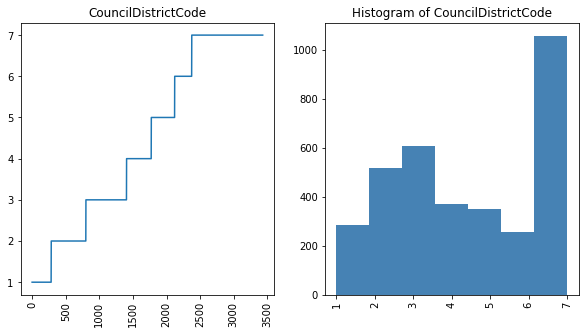

array([1, 2, 3, 4, 5, 6, 7])

In [14]:
var = "CouncilDistrictCode"
univariate_analysis.repartition_and_hist(data,var)
np.unique(data[var])

### Etude grossière des variables descriptives numériques

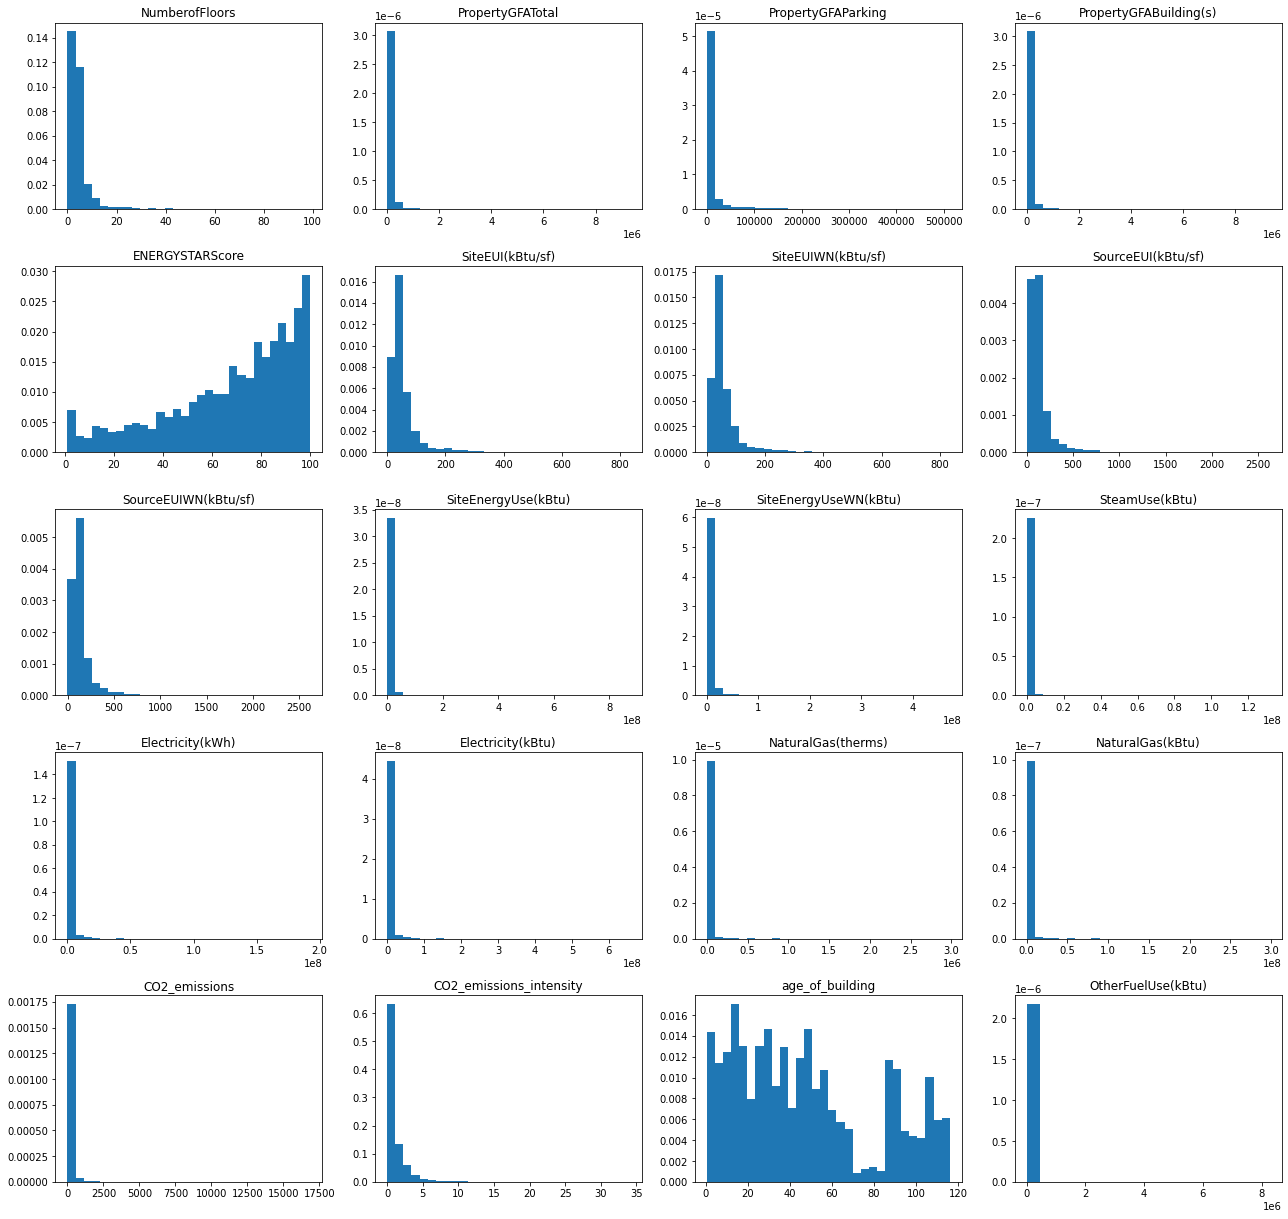

In [15]:
univariate_analysis.plot_multi_hist(data, numerical_var_in_data)

In [16]:
data[numerical_var_in_data].describe()

NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
count     3432.000000      3.432000e+03         3432.000000   
mean         4.688228      9.447183e+04         9651.224068   
std          5.458473      2.172062e+05        32953.838541   
min          0.000000      1.128500e+04           -1.500000   
25%          2.000000      2.846350e+04            0.000000   
50%          4.000000      4.419500e+04            0.000000   
75%          5.000000      9.044875e+04         2890.250000   
max         99.000000      9.320156e+06       512608.000000   

       PropertyGFABuilding(s)  ENERGYSTARScore  SiteEUI(kBtu/sf)  \
count            3.432000e+03      2656.000000       3429.000000   
mean             8.482061e+04        68.116717         54.445859   
std              2.048840e+05        26.377049         55.895447   
min             -8.451000e+03         1.000000          0.000000   
25%              2.726825e+04        52.500000         27.850000   
50%              4.213725e+04        75.500000         38.100001   
75%              8.192375e+04        89.625000         60.050000   
max              9.320156e+06       100.000000        834.400024   

       SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  \
count         3429.000000         3428.000000           3428.000000   
mean            57.489341          133.943174            138.589950   
std             57.157732          137.744473            137.275549   
min              0.000000            0.000000             -2.050000   
25%             29.600000           74.287500             79.500000   
50%             40.650001           95.900000            101.599999   
75%             64.750001          144.150000            149.900002   
max            834.400024         2620.000000           2620.000000   

       SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
count         3.429000e+03           3.429000e+03    3.428000e+03   
mean          5.398222e+06           5.311222e+06    2.737963e+05   
std           2.152855e+07           1.595773e+07    3.795683e+06   
min           0.000000e+00           0.000000e+00    0.000000e+00   
25%           9.293272e+05           9.898913e+05    0.000000e+00   
50%           1.792235e+06           1.940694e+06    0.000000e+00   
75%           4.195498e+06           4.402542e+06    0.000000e+00   
max           8.739237e+08           4.716139e+08    1.314066e+08   

       Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
count      3.428000e+03       3.428000e+03        3.428000e+03   
mean       1.087418e+06       3.710342e+06        1.361560e+04   
std        4.332754e+06       1.478348e+07        6.729292e+04   
min        2.000000e+00       7.000000e+00        0.000000e+00   
25%        1.859820e+05       6.345736e+05        0.000000e+00   
50%        3.440100e+05       1.173787e+06        3.211758e+03   
75%        8.214296e+05       2.802775e+06        1.152796e+04   
max        1.925775e+08       6.570744e+08        2.979090e+06   

       NaturalGas(kBtu)  CO2_emissions  CO2_emissions_intensity  \
count      3.428000e+03    3428.000000              3428.000000   
mean       1.361560e+06     119.311982                 1.092922   
std        6.729292e+06     534.287074                 1.769338   
min        0.000000e+00       0.090000                 0.000000   
25%        0.000000e+00       9.568750                 0.150000   
50%        3.211605e+05      33.842500                 0.545000   
75%        1.152789e+06      91.890000                 1.290000   
max        2.979090e+08   16870.980000                34.090000   

       age_of_building  OtherFuelUse(kBtu)  
count      3432.000000        3.330000e+03  
mean         47.145105        7.142301e+03  
std          33.169116        1.962790e+05  
min           0.500000        0.000000e+00  
25%          18.500000        0.000000e+00  
50%          41.500000        0.000000e+00  
75%          67.500000        0.000000e+00  
max  

Il n'a pas l'air d'y avoir de valeurs aberrantes dans ces données, je passe donc ce prétraitement.

### Etude grossière des variables descriptives catégorielles

In [17]:
dict_replace_modalities = {"PrimaryPropertyType" : {"Restaurant\n" : "Restaurant"},
                           "Neighborhood" : {"North":"NORTH", "Northwest":"NORTHWEST",
                                            "Delridge":"DELRIDGE", "DELRIDGE NEIGHBORHOODS":"DELRIDGE",
                                             "Ballard":"BALLARD", "Central" : "CENTRAL"}
                          }
def rename_modalities(data, dict_replace_modalities):
    res = data.copy()
    for var_name in dict_replace_modalities.keys():
        for old_mod, new_mod in dict_replace_modalities[var_name].items():
            res.at[res[var_name] == old_mod, var_name] = new_mod
    res.at[:,var_name] = res[var_name].cat.remove_unused_categories()
    return(res)
# data.at[data["PrimaryPropertyType"] == "Restaurant\n", "PrimaryPropertyType"] = "Restaurant"
# data.at[:,"PrimaryPropertyType"] = data["PrimaryPropertyType"].cat.remove_unused_categories()
data = rename_modalities(data,dict_replace_modalities)

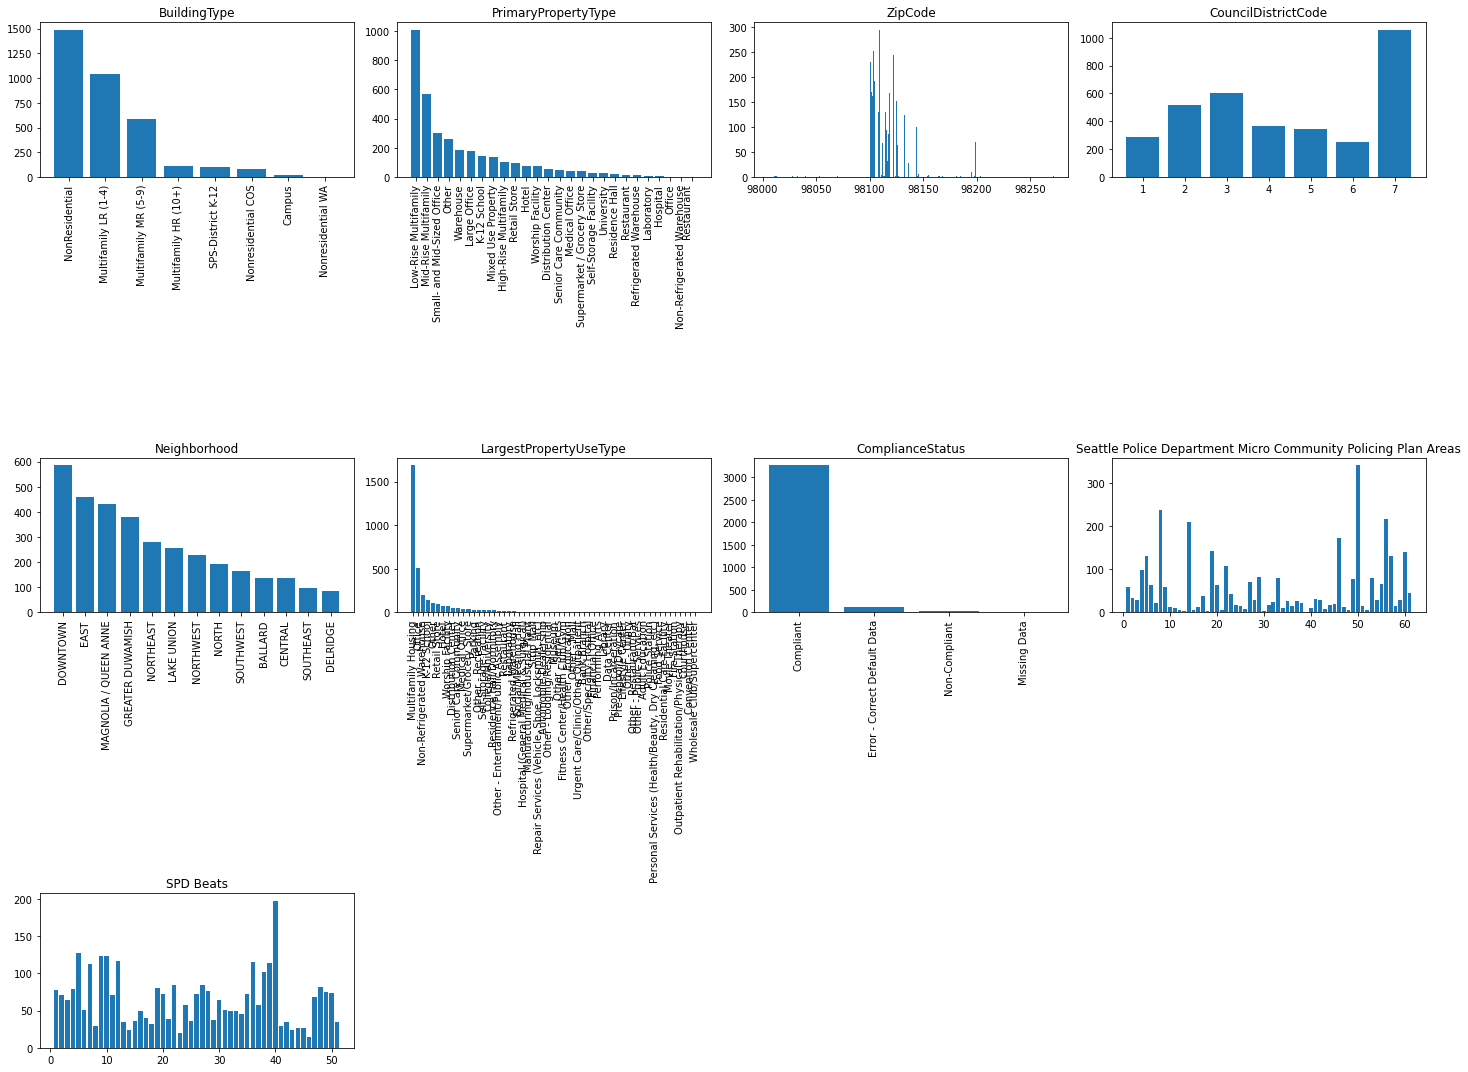

In [18]:
univariate_analysis.plot_multi_hist(data, categorical_var_in_data, figsize=(20,15))

# 2. Prétraitements 

## Gestion des types :
Les types semblent donc maintenant corrects (vérifiés avec df.dtypes ou df.info). 

In [19]:
print(data.info())
data[data.columns[data.dtypes=="object"]].head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3432 entries, 0 to 3431
Data columns (total 44 columns):
 #   Column                                                         Non-Null Count  Dtype   
---  ------                                                         --------------  -----   
 0   OSEBuildingID                                                  3432 non-null   int64   
 1   BuildingType                                                   3432 non-null   category
 2   PrimaryPropertyType                                            3432 non-null   category
 3   PropertyName                                                   3432 non-null   object  
 4   ZipCode                                                        3360 non-null   category
 5   TaxParcelIdentificationNumber                                  3431 non-null   object  
 6   CouncilDistrictCode                                            3432 non-null   category
 7   Neighborhood                                       

PropertyName TaxParcelIdentificationNumber  \
0  Mayflower park hotel                    0659000030   
1       Paramount Hotel                    0659000220   

    ListOfAllPropertyUseTypes SecondLargestPropertyUseType  \
0                       Hotel                          NaN   
1  Hotel, Parking, Restaurant                      Parking   

  ThirdLargestPropertyUseType YearsENERGYSTARCertified DefaultData Comments  \
0                         NaN                      NaN       False      NaN   
1                  Restaurant                      NaN       False      NaN   

  Outlier  
0     NaN  
1     NaN

Et j'ai supprimé les variables qui n'étaient ni catégorielles, ni numériques : 

In [20]:
data = data.drop(data.columns[data.dtypes=="object"], axis=1)

##  Suppression colonnes vides :

In [21]:
# var_in_data = data.columns.intersection(all_num_var)
# # num_data = data.loc[:,num_var_in_data]#.set_index(data["OSEBuildingID"])

##
## drop empty columns
##

nan_repartition = data.isna().sum(axis=0)
# nan_threshold = nan_repartition.mean()
nan_threshold = nan_repartition.quantile(0.95)
new_data = data.drop(data.columns[nan_repartition>nan_threshold], axis = 1)

print("I drop variables with less than", 
      data.shape[0]-np.floor(nan_threshold),
      "values")
print("That is more than", np.floor(nan_threshold), "missing values")
print("I have dropped", data.shape[1] - new_data.shape[1], "variables :",
      data.columns[[var not in new_data.columns for var in data.columns]])

data = new_data

I drop variables with less than 2371.0 values
That is more than 1061.0 missing values
I have dropped 2 variables : Index(['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'], dtype='object')


In [22]:
# ## 
# ## drop columns with no variation :
# ##

# data.var()

## Gestion des doublons :

In [23]:
## mise à jour des lists de variables : 
categorical_var_in_data = data.columns.intersection(categorical_var)
num_var_in_data = data.columns.intersection(all_num_var)

## est ce qu'il y a des doublons ?
dict_duplicates = duplicates.get_index_merge_duplicates(data, num_var_in_data, 1.15)
print(dict_duplicates)

{}


## Inférence valeurs manquantes : 

In [24]:
X_var = numerical_var_in_data[[var not in ["CO2_emissions",
                             "SiteEnergyUse(kBtu)","ENERGYSTARScore"] for var in numerical_var_in_data]]
X = data[data.columns.intersection(float_var)]#.set_index(data["OSEBuildingID"])
y = data[["OSEBuildingID", "CO2_emissions","SiteEnergyUse(kBtu)"]]#.reindex(data["OSEBuildingID"])


MSE = 154.083 (+/-37.478) for {'n_neighbors': 1}
MSE = 140.025 (+/-43.065) for {'n_neighbors': 2}
MSE = 135.817 (+/-42.241) for {'n_neighbors': 3}
MSE = 134.423 (+/-41.752) for {'n_neighbors': 4}
MSE = 134.132 (+/-40.908) for {'n_neighbors': 5}
MSE = 133.879 (+/-40.489) for {'n_neighbors': 6}
MSE = 133.916 (+/-40.190) for {'n_neighbors': 7}
MSE = 134.094 (+/-39.865) for {'n_neighbors': 8}
MSE = 134.070 (+/-39.599) for {'n_neighbors': 9}
MSE = 134.276 (+/-39.341) for {'n_neighbors': 10}
MSE = 133.936 (+/-39.643) for {'n_neighbors': 11}
MSE = 133.976 (+/-39.446) for {'n_neighbors': 12}
MSE = 134.141 (+/-39.239) for {'n_neighbors': 13}
MSE = 134.336 (+/-39.093) for {'n_neighbors': 14}


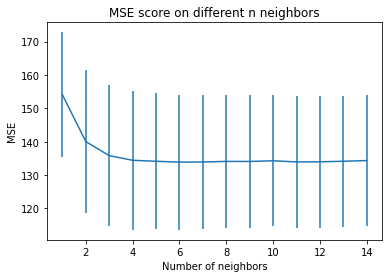

In [25]:
##
## Standardize X : 
##

standardizer = preprocessing.StandardScaler().fit(X)
X_std = standardizer.transform(X)
X_std = pd.DataFrame(X_std, columns= X.columns, index = X.index)

# ##
# ## Set the best number of neighbors
# ##

my_meth = KNNImputer
param_grid = {"n_neighbors" : np.arange(1,15,1)}
cv = 4

# res = missing_values_treatment.launch_my_pseudo_CV(X_std,my_meth,param_grid, cv = cv)
# # Save dictionnary of results : 
# import pickle
# with open(res_path+"set_n_KNN_impute"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

import pickle
with open(res_path+"set_n_KNN_impute"+".pkl", "rb") as f :
        res = pickle.load(f)

fig_name = "set_n_KNN_impute.jpg"
missing_values_treatment.plot_MSE_scores_KNN_impute(res, param_grid, fig_name)

In [26]:
## Impute missing values :
imputer = KNNImputer(n_neighbors=4)
pred_std = imputer.fit_transform(X_std)
pred_std = pd.DataFrame(pred_std, index = X.index, columns = X.columns)

## Inverse-standardize : 
# pred_std = pd.read_csv(res_path+"dataframe_std_KNN_impute.csv",index_col=0)
pred = standardizer.inverse_transform(pred_std)
pred = pd.DataFrame(pred, index = X.index, columns = X.columns)

## uncomment to add predicted values in data : 
data.at[:,pred.columns.values]= pred

## Separation des variables dans le permis de construire : 
En utilisant la description des variables données sur [ce site](https://www.splitgraph.com/seattle-gov/2018-building-energy-benchmarking-7rac-kyay), j'ai classé celles qui me semblaient être dans le permis de construction, et les variables liées à la consommation électrique. Je rappelle que j'ai faire le traitement des variables d'émission de CO2 au préalable.

In [27]:
data.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'CouncilDistrictCode', 'Neighborhood', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'ComplianceStatus', 'CO2_emissions',
       'CO2_emissions_intensity', 'age_of_building', 'OtherFuelUse(kBtu)',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'SPD Beats', 'ZipCode2015'],
      dtype='object')

In [28]:
var_in_building_permit = ['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
                          'CouncilDistrictCode', 'Neighborhood',
                          'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
                          'LargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)', 'LargestPropertyUseType',
                          'age_of_building', "ZipCode", "ZipCode2015"
                          'Seattle Police Department Micro Community Policing Plan Areas',
                          'SPD Beats']

CO2_var = ['CO2_emissions','CO2_emissions_intensity']

energy_var = ['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)',
              'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
              'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
              'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 
              'NaturalGas(therms)','NaturalGas(kBtu)',
              'OtherFuelUse(kBtu)'
             ]


# 3. Analyse univariée :

## Données numériques : 

L'histogramme sur la plupart des variables numériques ne permettait pas de distinguer la répartition des données. Je passe en échelle logarithmique les variables où les histogramme étaient peu lisibles, pour voir s'il on arrive mieux à distinguer la distribution avec cette transformation. La première étape pour cela est de retirer les valeurs négatives, qui sont présentes dans certaines variables :

In [29]:
num_data_positive = data[numerical_var_in_data].drop(["ENERGYSTARScore", "age_of_building", "NumberofFloors"], axis = 1)
num_data_positive[num_data_positive<0]= np.nan
num_data_log = np.log(num_data_positive+1)

## create bool dict for log-transfo
dict_var_log_transfo = {}
for var in data.columns : 
    if var in num_data_log.columns.values :
        dict_var_log_transfo[var] = True
    else :
        dict_var_log_transfo[var] = False

Variables de description :


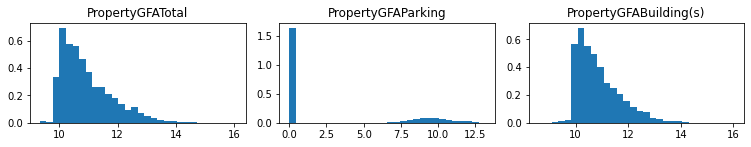

In [30]:
print("Variables de description :")
univariate_analysis.plot_multi_hist(num_data_log, var_in_building_permit, figsize=(14,9))

Pour rappel, "GFA" fait référence à la surface au rez-de-chaussée. Ainsi, le log de la surface au sol des immeubles a l'air de suivre une loi à peu près normale, et une partie importante d'immeuble n'a pas de surface de parking.

Variables de description sans échelle au log :


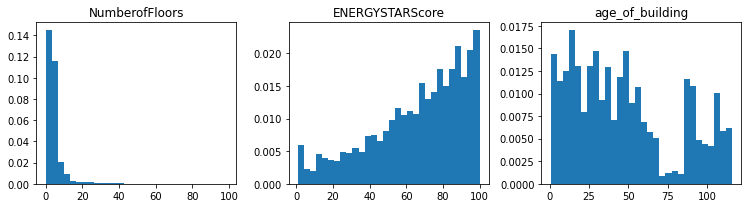

In [31]:
print("Variables de description sans échelle au log :")
univariate_analysis.plot_multi_hist(data, ["ENERGYSTARScore", "age_of_building", "NumberofFloors"], 
                                    figsize=(14,3))

Variables énegétiques :


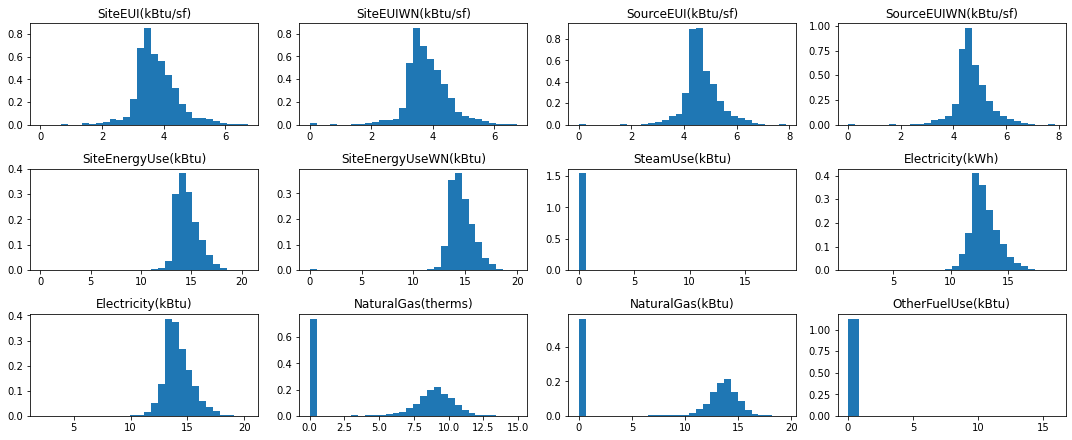

In [32]:
print("Variables énegétiques :")
univariate_analysis.plot_multi_hist(num_data_log, energy_var, figsize=(15,8))

Les variables liées à la consommation électrique ont l'air de suivre des lois normales, bien que la variance a l'air petite, et les queues de distribution assez lourdes. Les variables de consommation de gaz sont la somme d'une distribution de dirac en 0 et d'une loi normale.  

Variable émission CO2


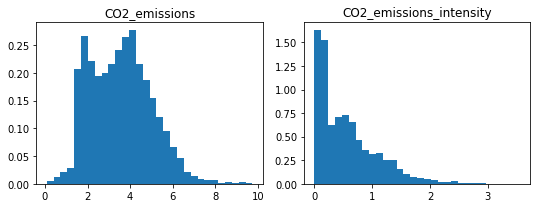

In [33]:
print("Variable émission CO2")
univariate_analysis.plot_multi_hist(num_data_log, CO2_var, figsize=(15,3))

Les variables liées à l'émission de CO2 ont l'air d'être la somme de deux distributions : une première avec une variance et moyenne petites, et une deuxième une peu plus grande (correspondant à la deuxième bosse sur la droite)
<!-- ##TODO : description à compléter -->


### Retrait variables fortement correlées : 

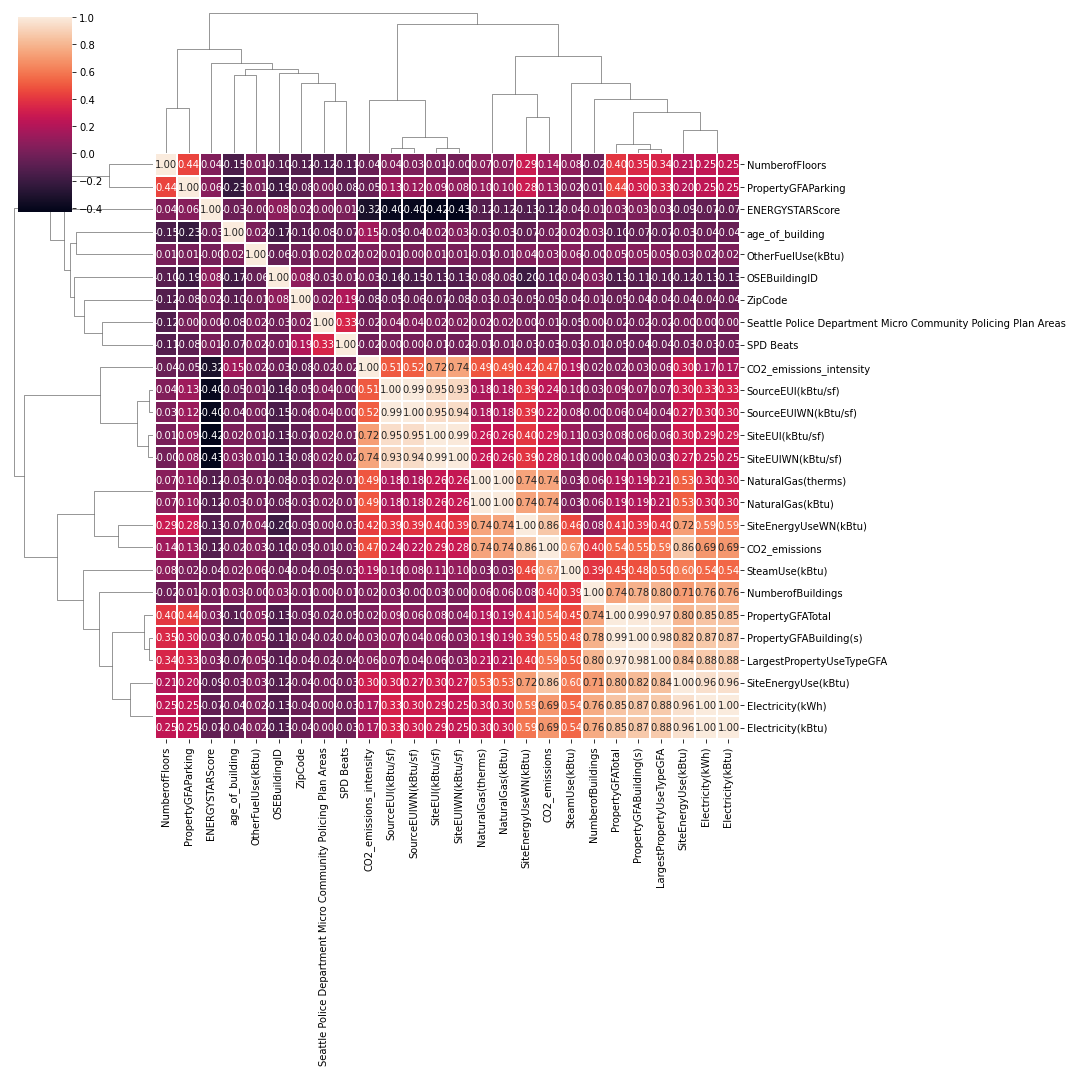

In [34]:
sns.clustermap(data.corr(), annot=True, linewidths=0.1, fmt='.2f', figsize=(15, 15))
plt.show()

On distingue clairement quelques blocs de variables très corrélées : 
* Electricity : 'Electricity(kWh)', 'Electricity(kBtu)', (et 'SiteEnergyUse(kBtu)' que j'ai laissé à part car variable de réponse)
* lui même très fortement corrélé au groupe Ground Floor Area : 'PropertyGFATotal','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA'
* Natural Gas : 'NaturalGas(therms)', 'NaturalGas(kBtu)'
* Energy Use Intensity : 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)'

Je propose donc de regrouper les variables consommation électrique sous la variable "electricity", celles consernant la surface au sol en "ground_floor_area", la consommation de gaz naturel sous "natural_gas" et les variables EUI sous "energy_use_intensity". Les valeurs prise correspondront aux valeurs de la variable la plus corrélée à nos variables de réponse, soit l'émission de CO2 et la consommation d'énergie. 

In [35]:
dict_corr_var = {"electricity":['Electricity(kWh)', 'Electricity(kBtu)'],
        "ground_floor_area":['PropertyGFATotal','PropertyGFABuilding(s)','LargestPropertyUseTypeGFA'],
        "natural_gas":['NaturalGas(therms)', 'NaturalGas(kBtu)'],
        "energy_use_intensity":['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 
                                'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)']}
new_data = data.copy()
for res_var in dict_corr_var.keys() :
    list_of_var = dict_corr_var[res_var]
    corr_matrix = data[np.concatenate((list_of_var, ["CO2_emissions","SiteEnergyUse(kBtu)"]))].corr()
    ## extract the column with max absolute mean of corr with the response variables 
    var_to_keep = corr_matrix.loc[["CO2_emissions","SiteEnergyUse(kBtu)"],list_of_var].abs().mean().idxmax()
    ## drop columns too much correlated : 
    for var in list_of_var :
        if var != var_to_keep : 
            new_data = new_data.drop(var, axis = 1)
data = new_data

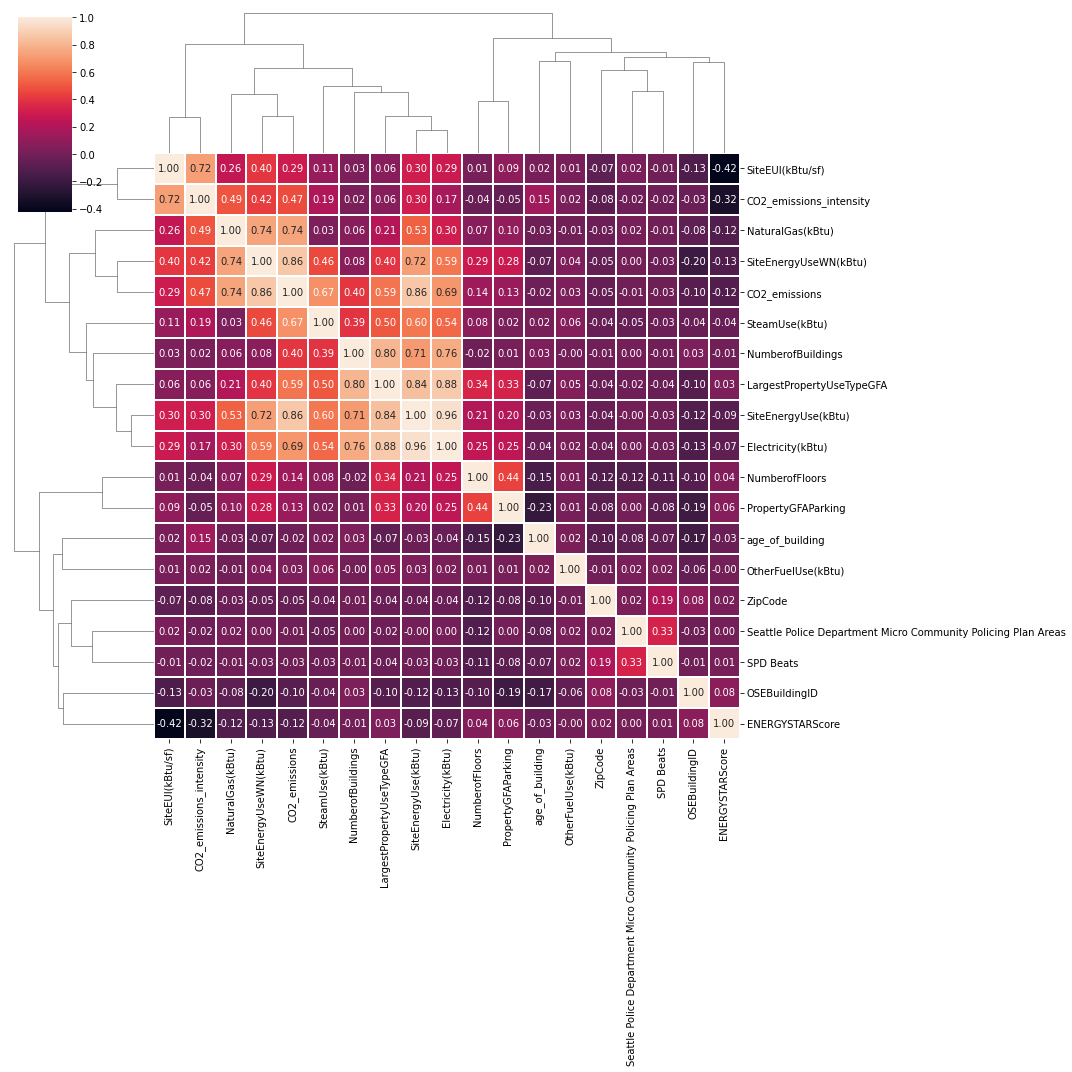

In [36]:
sns.clustermap(data.corr(), annot=True, linewidths=0.1, fmt='.2f', figsize=(15, 15))
plt.show()

In [37]:
num_training_var = data.columns[data.dtypes==float]
num_training_var = num_training_var.intersection(var_in_building_permit)
num_output_var = ["CO2_emissions","SiteEnergyUse(kBtu)"]
num_other_var = np.setdiff1d(data.columns, np.concatenate((num_output_var, var_in_building_permit)))

### Distribution des variables sélectionnées : 
J'ai été confrontée à certaines difficultés pour afficher plusieurs graphes, groupés par 2 verticalement. J'ai utilisé [une solution proposée sur ce forum](https://stackoverflow.com/questions/49054631/fill-matplotlib-subplots-by-column-not-row) dont j'ai copié la fonction ```row_based_idx```. 
J'ai intégré ces fonctions à mon script dédié "univariate_analysis.py"

In [38]:
from univariate_analysis import *

#### Distribution des variables dans le permis de construction : 

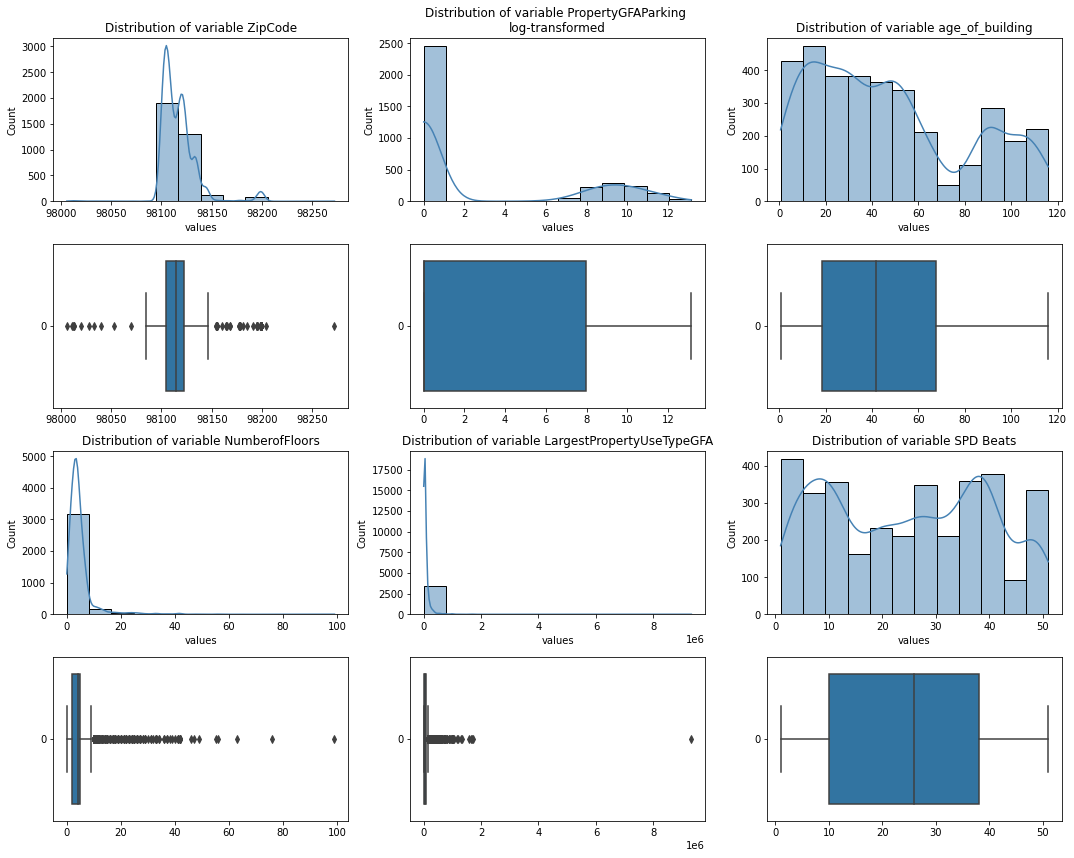

In [39]:
plot_multi_hist_and_boxplot(data, num_training_var,  dict_var_log_transfo, nb_fig_in_line = 3, figsize=(15,12))

##TODO : faire une description de ces graphes

<!-- #### Distribution des variables de sortie :  
plot_multi_hist_and_boxplot(data, num_output_var, nb_fig_in_line = 2, figsize=(12,7))
dict_log = {var: True for var in num_output_var}
plot_multi_hist_and_boxplot(data, num_output_var, dict_log, nb_fig_in_line = 2, figsize=(12,7))
-->

## Données catégorielles 
### Etude descriptive univariée

In [40]:
cat_training_var = data.columns[data.dtypes=="category"].intersection(var_in_building_permit)

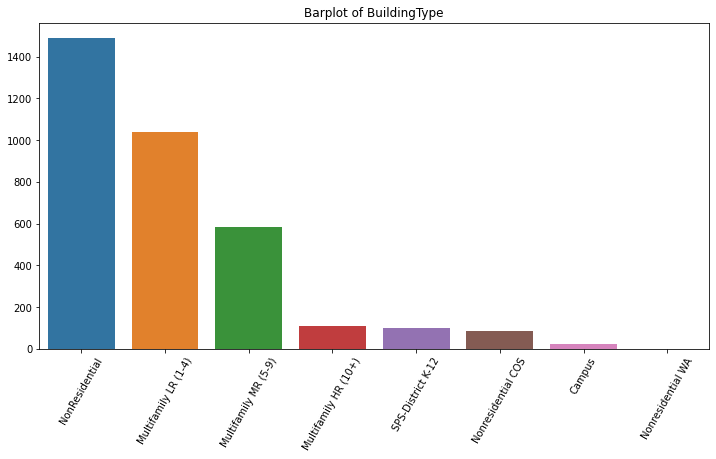

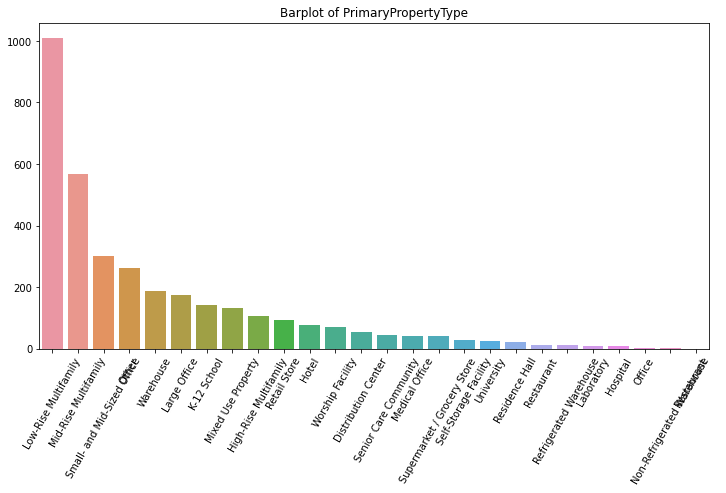

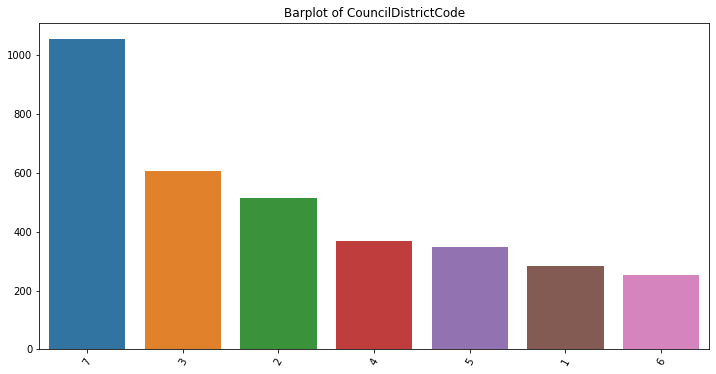

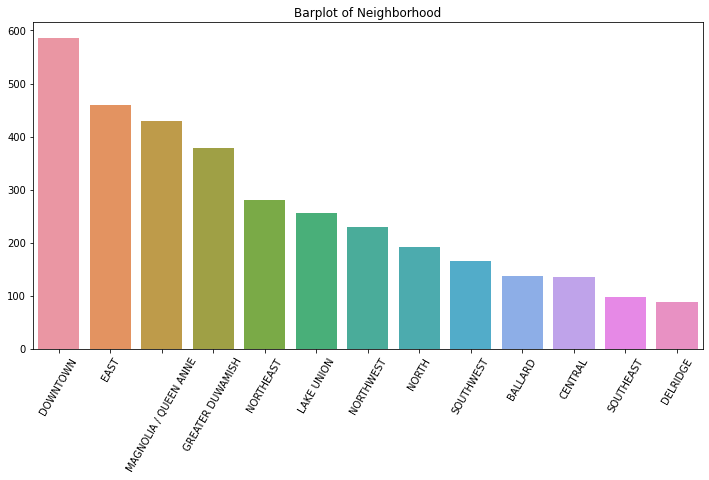

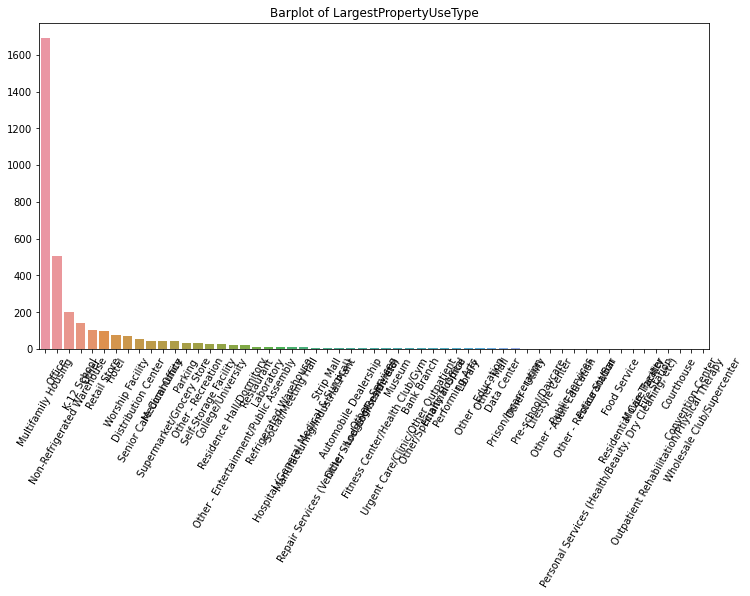

In [41]:
def plot_barplot(y):
    plt.title("Barplot of "+y.name)
    if y.value_counts().shape[0] > 5 : 
        ax = sns.barplot(x=y.index, y=y.values, order =y.sort_values(ascending=False).index)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
    else:
        sns.barplot(x=y.values, y=y.index, order=y.sort_values(ascending=False).index)

for colname in cat_training_var:
    plt.figure(figsize=(12, 6))
    y = data[colname].value_counts().sort_values(ascending=False)
    plot_barplot(y)
    plt.show()

Comme l'équipe ne s'intéresse qu'aux bâtiments non destinés à l'habitation, je vais retirer les individus dont la variable catégorielle "BuildingType" prend la modalité "Multifamily HR (10+)", "Multifamily MR (5-9)", et "Multifamily LR (1-4)"

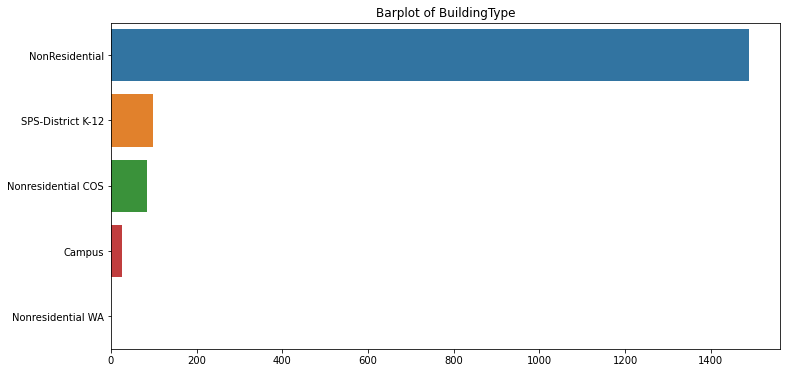

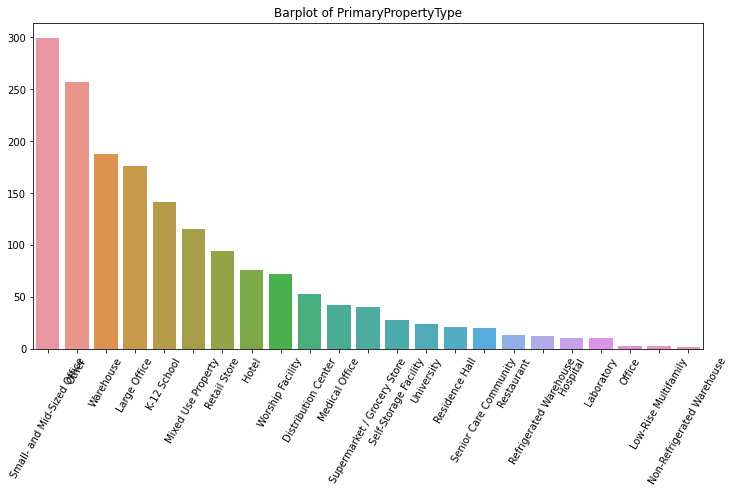

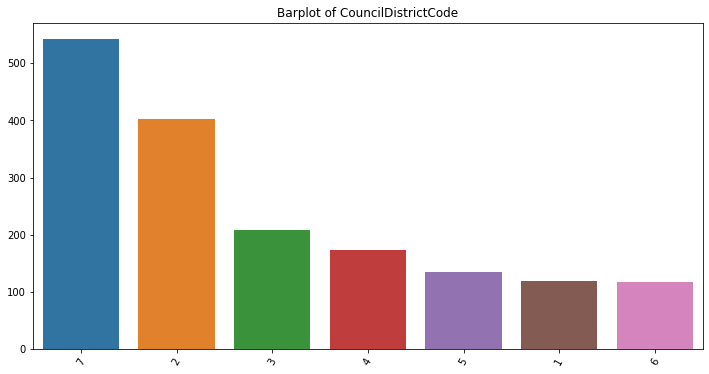

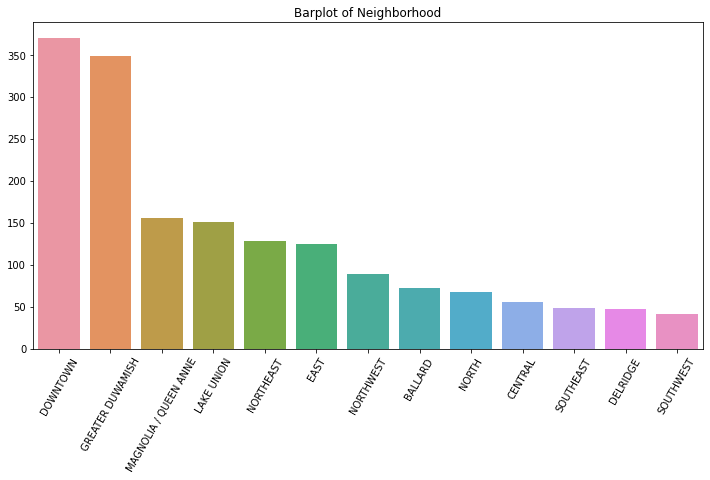

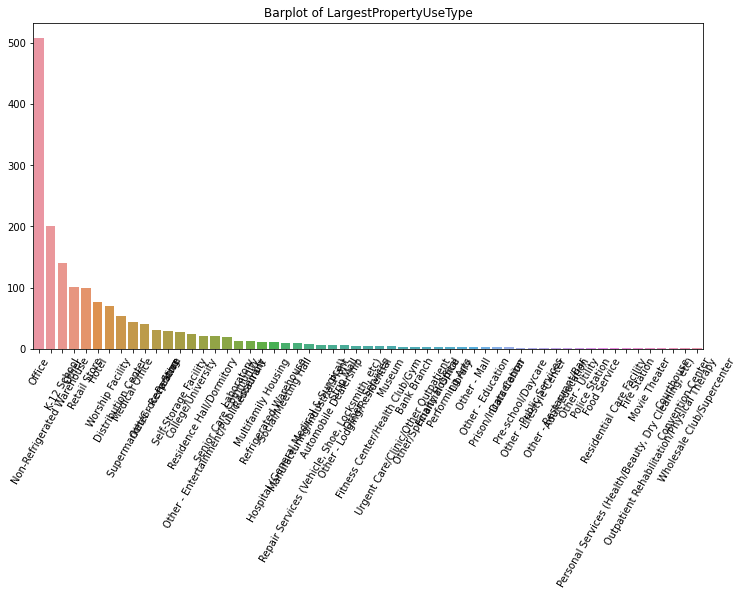

In [42]:
residential_building_type = [ "Multifamily HR (10+)", "Multifamily MR (5-9)", "Multifamily LR (1-4)"]
data_non_resid = data.drop(data[data["BuildingType"].isin(residential_building_type)].index, axis = 0)
for cat_name in data.columns.intersection(cat_training_var):
    data_non_resid[cat_name] = data_non_resid[cat_name].cat.remove_unused_categories()
for colname in cat_training_var:
    plt.figure(figsize=(12, 6))
    y = data_non_resid[colname].value_counts().sort_values(ascending=False)
    plot_barplot(y)
    plt.show()

## Etude des deux variables de réponse 

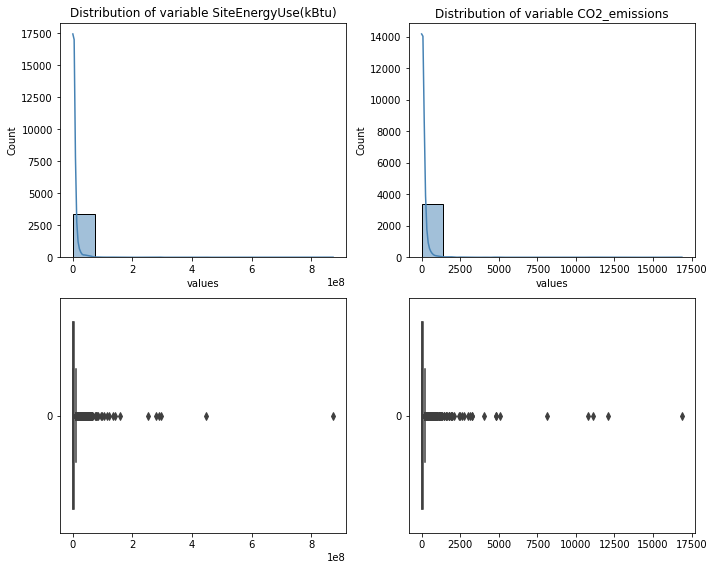

SiteEnergyUse(kBtu)  CO2_emissions
count         3.432000e+03    3432.000000
mean          5.397231e+06     119.260943
std           2.151962e+07     533.990955
min           9.313226e-10       0.090000
25%           9.293125e+05       9.550000
50%           1.791223e+06      33.757500
75%           4.197331e+06      91.890000
max           8.739237e+08   16870.980000

In [43]:
Y = data[["SiteEnergyUse(kBtu)","CO2_emissions"]]
univariate_analysis.plot_multi_hist_and_boxplot(Y,nb_fig_in_line=2,figsize=(10,8))
plt.show()
Y.describe()

Je passe en échelle logarithmique pour voir quelque chose :

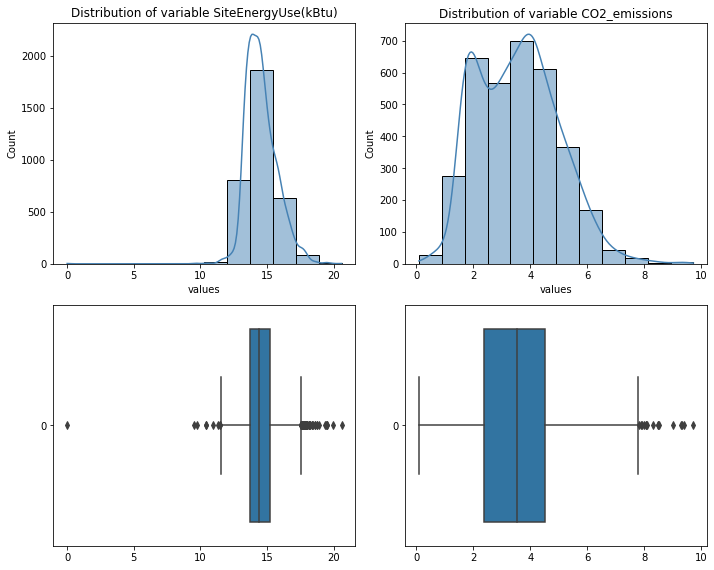

In [44]:
Y_log = np.log(data[["SiteEnergyUse(kBtu)","CO2_emissions"]]+1)
univariate_analysis.plot_multi_hist_and_boxplot(Y_log,nb_fig_in_line=2,figsize=(10,8))
plt.show()

dict_log = {var: True for var in num_output_var}

Le log-consommation  d'énergie a l'ai de suivre grossièrement une loi gaussienne, de moyenne 15 et d'écart-type petit. La log-émission de CO2 a l'air d'être la somme de deux gaussiennes : une première centrée en 2 et la deuxième en 5.

Et lorsque l'on ne regarde plus que les bâtiments non résidentiels : 

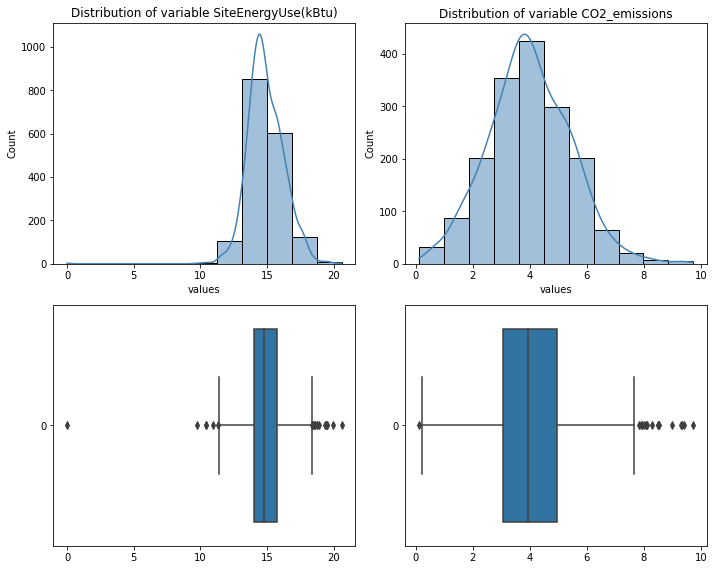

In [45]:
Y_log = np.log(data_non_resid[["SiteEnergyUse(kBtu)","CO2_emissions"]]+1)
univariate_analysis.plot_multi_hist_and_boxplot(Y_log,nb_fig_in_line=2,figsize=(10,8))
plt.show()

La distribution pout la log-consommation  d'énergie n'a pas changé, alors que la log-émission de CO2 a perdu la deuxiéme bosse. Celà signifie qu'il sera nécessaire de retirer les batiments résidentiels pour prédire les émissions de CO2. 

Without residential buildings :
SiteEnergyUse(kBtu) :
	 gini = 0.7132230985588934
	 AUC = 0.14338845072055326
CO2_emissions :
	 gini = 0.7541953158642709
	 AUC = 0.12290234206786452


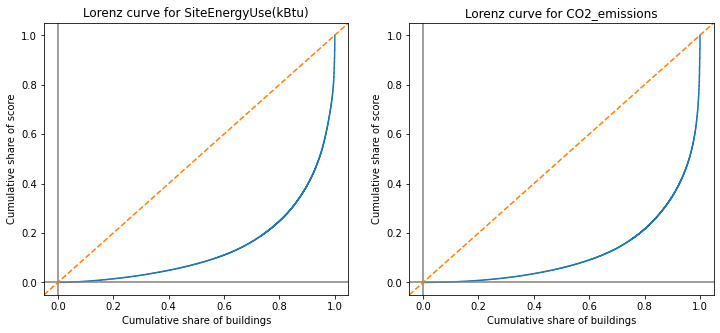

In [46]:
print("Without residential buildings :")
Y =data_non_resid[["SiteEnergyUse(kBtu)","CO2_emissions"]]
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
univariate_analysis.plot_lorenz_curve(Y.iloc[:,0])
plt.subplot(1,2,2)
univariate_analysis.plot_lorenz_curve(Y.iloc[:,1])

# 4. Analyse multivariée :



In [47]:
num_data = data[data.columns.intersection(np.concatenate((num_training_var,[ "CO2_emissions", "SiteEnergyUse(kBtu)"])))]
num_data.head()

ZipCode  NumberofFloors  PropertyGFAParking  LargestPropertyUseTypeGFA  \
0  98101.0            12.0                 0.0                    88434.0   
1  98101.0            11.0             15064.0                    83880.0   
2  98101.0            41.0             98359.0                   756868.0   
3  98101.0            10.0                 0.0                    61320.0   
4  98121.0            18.0             37230.0                   123445.0   

   SiteEnergyUse(kBtu)  CO2_emissions  age_of_building  SPD Beats  
0           7103895.25        249.705             88.5       31.0  
1           8371084.00        279.685             19.5       31.0  
2          72858840.00       2075.380             46.5       31.0  
3          17511952.00       1111.385             89.5       31.0  
4          14500852.50        506.355             35.5       31.0

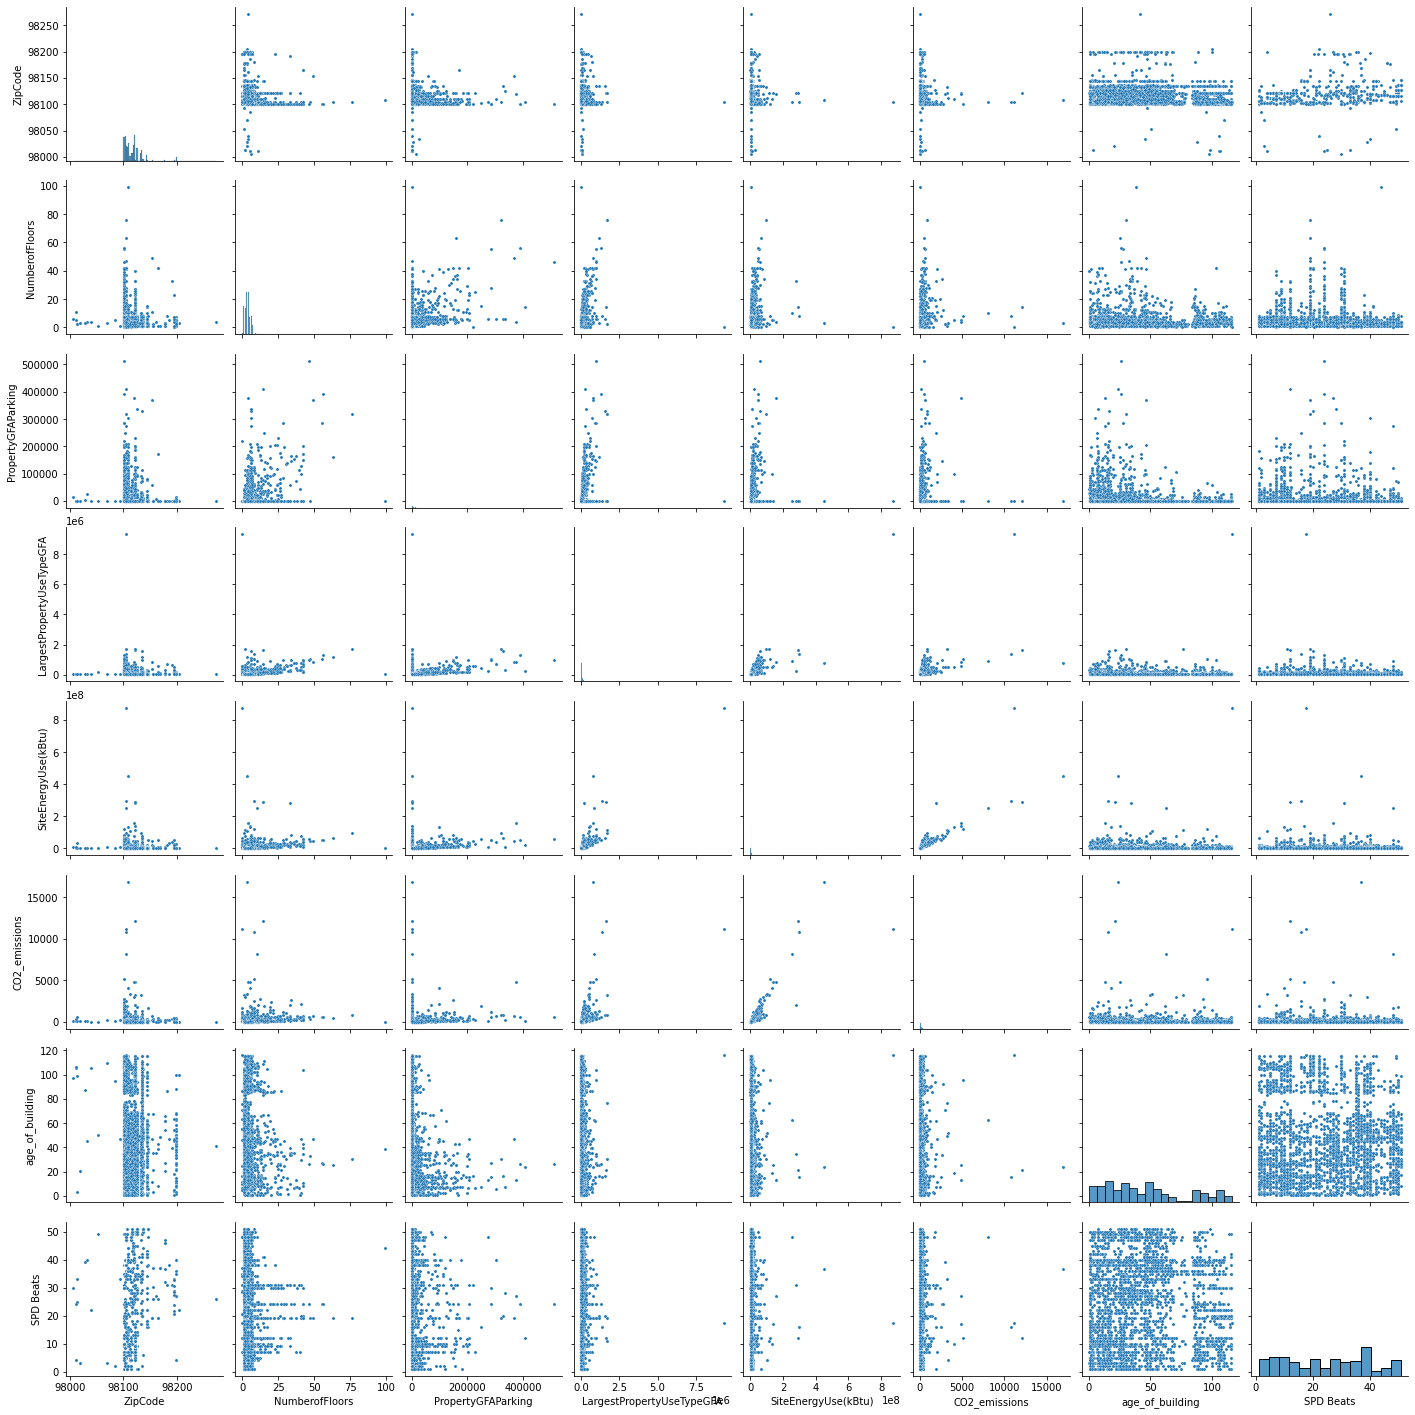

In [48]:
sns.pairplot(num_data, diag_kind="hist", plot_kws={"s": 10, "alpha":1})

Table avec les variables en log-transform : 

In [49]:

dict_var_log_transfo["SiteEnergyUse(kBtu)"]=True 
dict_var_log_transfo["CO2_emissions"]=True 
def df_log_transform(X_, num_var = []):
    ## set num var :
    if len(num_var) == 0 :
        num_var = X_.columns[X_.dtypes==float].values
    else : 
        num_var = X_.columns.intersection(num_var)
    ## init res 
    X_log = X_.copy()
    X_log_num = X_log[num_var]
    ## replace neg values with 0 : 
    index_negative = np.where(X_log_num<10**(-9))
    for i in range(len(index_negative[0])):
        X_log_num.iat[index_negative[0][i],index_negative[1][i]] = 0
    index_inf = np.where(X_log_num>10**9)
    for i in range(len(index_inf[0])):
        X_log_num.iat[index_inf[0][i],index_inf[1][i]] = 0
    X_log.at[:,num_var] = np.log(X_log_num + 1)
    return(X_log)

log_num_var = [var for var in dict_var_log_transfo.keys() if dict_var_log_transfo[var]]
# data_log_transfo = df_log_transform(data, log_num_var)
data_log_transfo = df_log_transform(data_non_resid, log_num_var)

## Consommation d'énergie

### Consommation d'énergie VS variables numériques
Commençons par une régression linéaire entre la variable de sortie ```SiteEnergyUse(kBtu)``` avec les variables du permis de construction : 

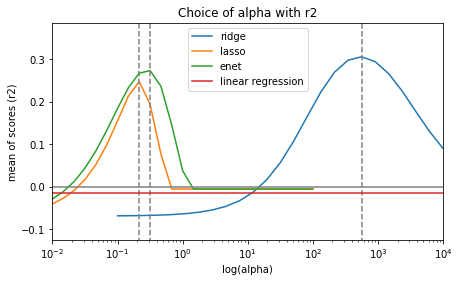

ridge  : 


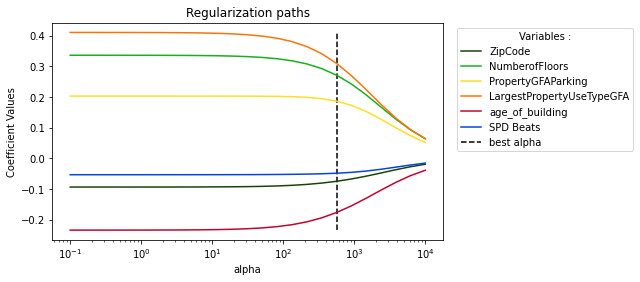

lasso  : 


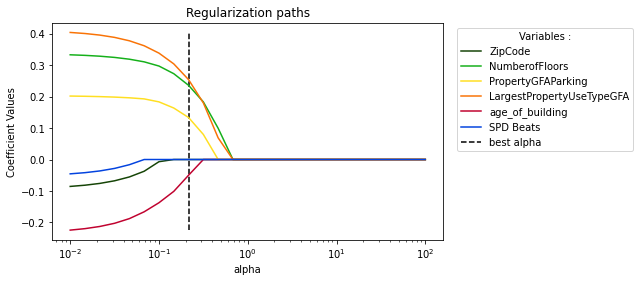

enet  : 


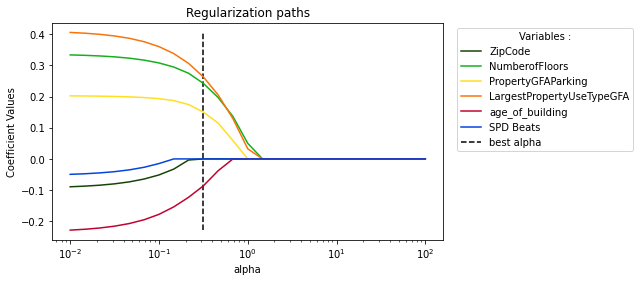

score execution_time  best_alpha
lr    -0.015002       0.003585        None
ridge  0.080793       0.083114  562.341325
lasso  0.036088       0.080764    0.215443
enet   0.061792       0.076797    0.316228

In [50]:
from multivariate_analysis import *

# y = data["SiteEnergyUse(kBtu)"]
# X = data[num_training_var]

y = data_log_transfo["SiteEnergyUse(kBtu)"].copy()
X = data_log_transfo[num_training_var].copy()

# CV for LR init
dict_lr_model= {"ridge" : linear_model.Ridge(),
                "lasso" : linear_model.Lasso(),
                "enet" : linear_model.ElasticNet()}
dict_param_grid = {"ridge": np.logspace(-1, 4, 25),
                   "lasso": np.logspace(-2, 2, 25),
                   "enet" : np.logspace(-2, 2, 25),
                  }
score_name = "r2"
# plot parameters
figsize = (7,4)
fig_name = None ## change to save plot

compute_LR_CV(X, y, dict_lr_model, dict_param_grid, score_name, figsize, fig_name)

## reset params in model


La variable "SDP Beats" ne semble avoir aucun impacte sur la prediction de la consommation d'énergie (coefficients lasso = 0) . Si elle a le même comportement avec la variable de consommation d'énergie, elle serait à retirer.

### Consommation d'énergie VS variables catégorielles : 

nb : j'ai gardé l'échelle logarithmique pour l'ANOVA qui suit. 

SiteEnergyUse(kBtu) : eta² = 0.03


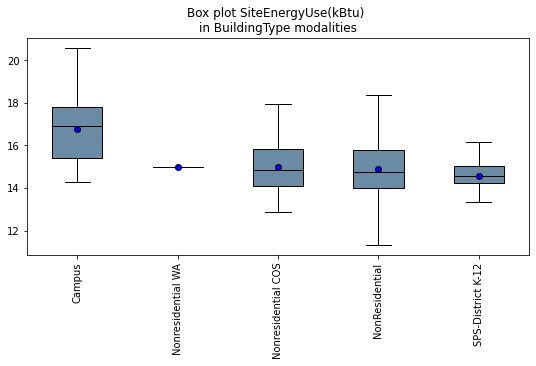

SiteEnergyUse(kBtu) : eta² = 0.37


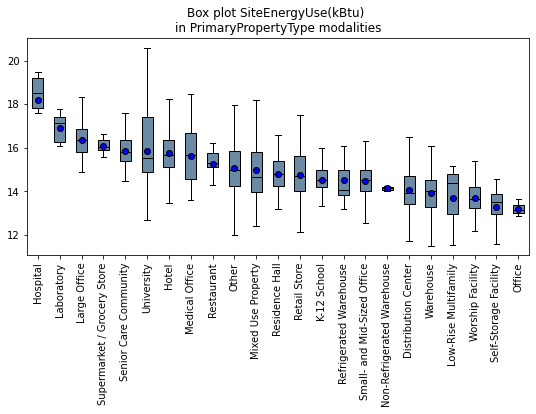

SiteEnergyUse(kBtu) : eta² = 0.07


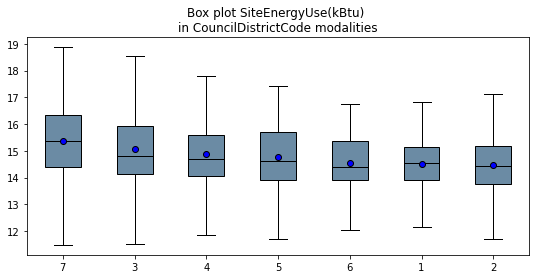

SiteEnergyUse(kBtu) : eta² = 0.08


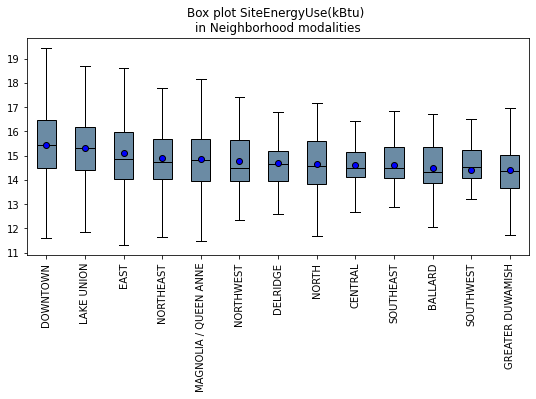

SiteEnergyUse(kBtu) : eta² = 0.29


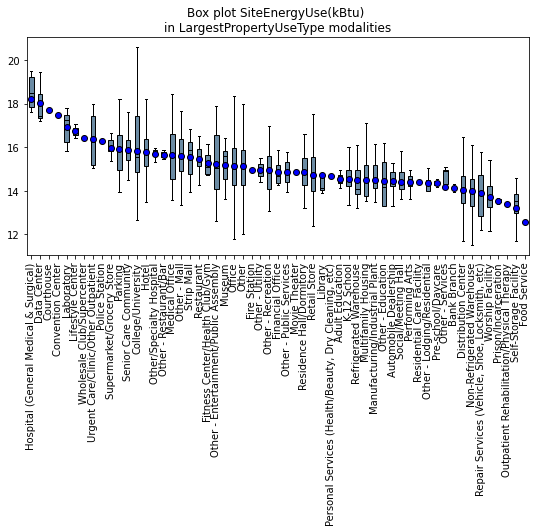

In [51]:
num_var="SiteEnergyUse(kBtu)"
for cat_var in cat_training_var :
    # remove  non used modalities :
    data_log_transfo[cat_var] = data_log_transfo[cat_var].cat.remove_unused_categories()
    plt.figure(figsize=(9,4))
    plot_boxplot(data_log_transfo, cat_var, 
                 num_var="SiteEnergyUse(kBtu)",sort=True)
    eta2 = eta_squared(x=data_log_transfo[cat_var], y= data_log_transfo["SiteEnergyUse(kBtu)"])
    print(num_var, ": eta² =",np.round(eta2,2))
    plt.show()

Cette ANOVA nous permet de sélectionner les variables catégorielles pour lesquelles la variable "consommation d'énergie" est significativement différentes dans les modalités. J'ai donc gardé les variables dont l'indice $\eta^2$ est supérieur à $0.1$, j'ai donc retiré ```CouncilDistrictCode```, ```ComplianceStatus``` et ```Neighborhood``` des variables d'entrainement pour la consommation d'énergie. 

## Emission de CO2 


### Emission de CO2 VS variables numériques

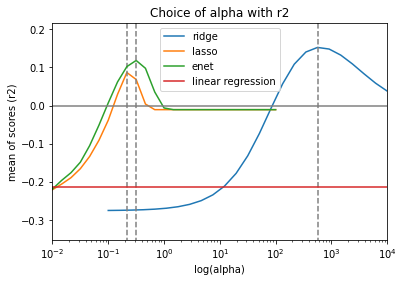

ridge  : 


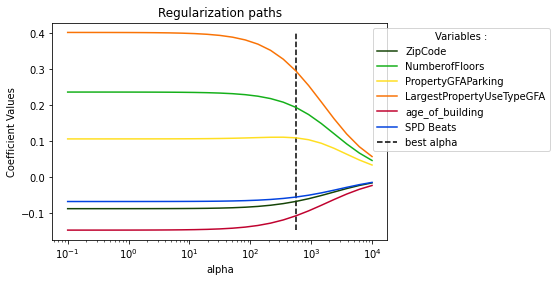

lasso  : 


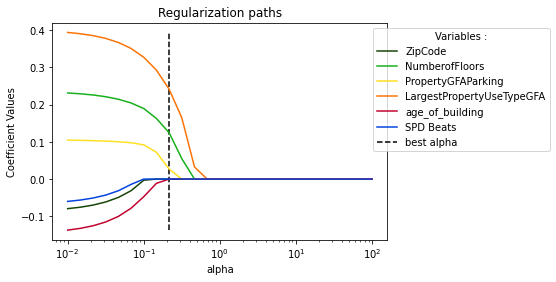

enet  : 


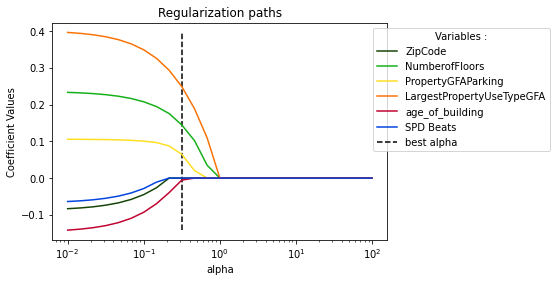

score execution_time  best_alpha
lr    -0.212577       0.003135        None
ridge -0.088778       0.083641  562.341325
lasso -0.040185       0.075506    0.215443
enet  -0.024282       0.071934    0.316228

In [52]:
# y = data["CO2_emissions"]
# X = data[num_training_var]
y = data_log_transfo["CO2_emissions"]
X = data_log_transfo[num_training_var]

# CV for LR init
alpha_values =  np.logspace(-2, 3, 50)
dict_lr_model= {"ridge" : linear_model.Ridge(), "lasso" : linear_model.Lasso(),
                "enet" : linear_model.ElasticNet()}
score_name = "r2"
# plot parameters
figsize = (8,5)
fig_name = None ## change to save plot

compute_LR_CV(X, y, dict_lr_model, dict_param_grid, score_name, fig_name)

La variable "SPD Beats" n'a pas non plus d'effet fort sur la consommation d'énergie, je la retire de cette étude. 

In [53]:
data_log_transfo = data_log_transfo.drop("SPD Beats", axis =1)
data = data.drop("SPD Beats", axis =1)

BuildingType : eta² = 0.035


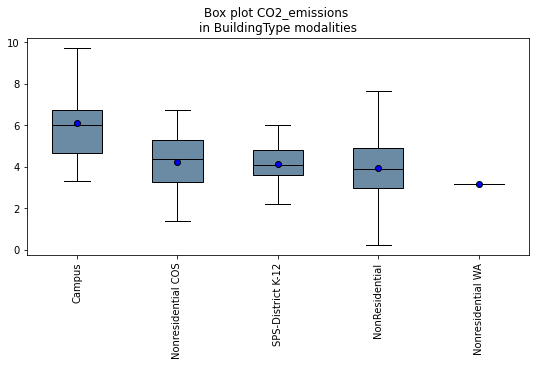

PrimaryPropertyType : eta² = 0.321


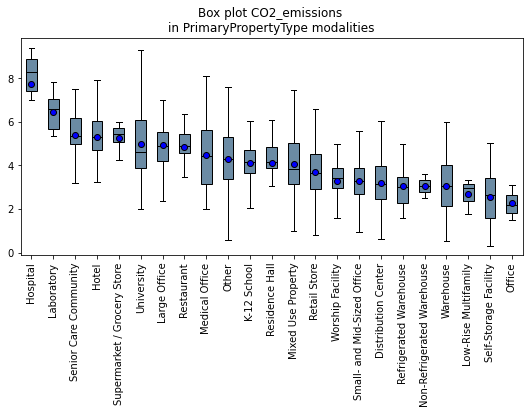

CouncilDistrictCode : eta² = 0.049


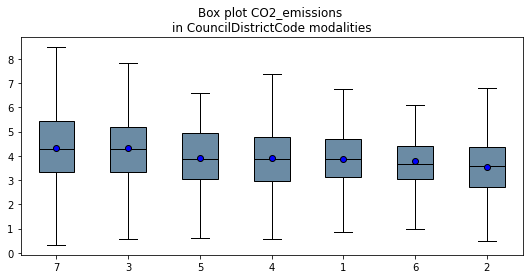

Neighborhood : eta² = 0.055


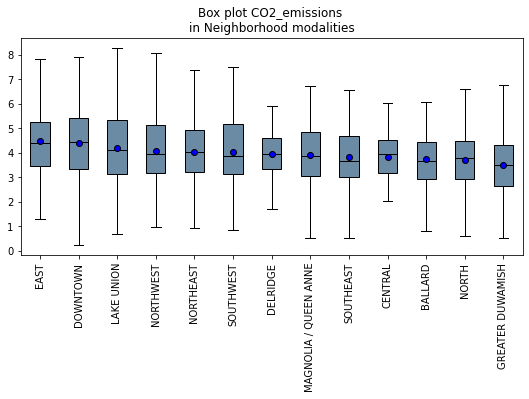

LargestPropertyUseType : eta² = 0.274


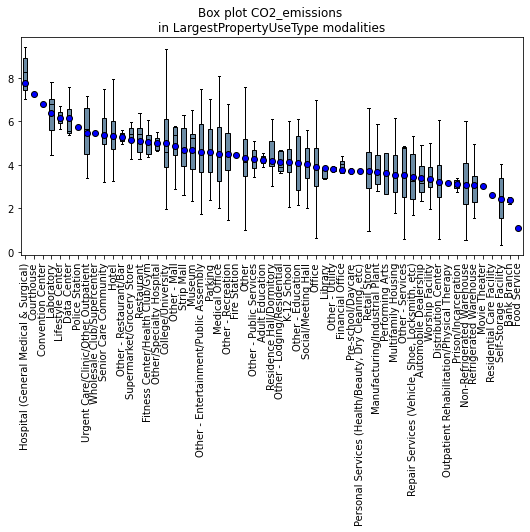

In [54]:
for var in cat_training_var :
    plt.figure(figsize=(9,4))
    plot_boxplot(data_log_transfo, var, "CO2_emissions",sort=True)
    eta2 = eta_squared(x=data_log_transfo[var], y=data_log_transfo["CO2_emissions"])
    print(var, ": eta² =",np.round(eta2,3))
    plt.show()

De la même façon que pour la consommation d'énergie, l'émission de CO2 n'a pas de structure forte pour les variables ```CouncilDistrictCode``` et ```ComplianceStatus``` que je vais donc retirer des variables d'entrainement. Par ailleurs, il serait pertinent d'essayer de regrouper les quartiers (variable ```Neighborhood```), car il y a l'air d'y avoir 3 ou 4 régimes différents sur ces derniers.

In [55]:
cat_training_var = cat_training_var.drop(["CouncilDistrictCode"])#,"Neighborhood"])

# L'Energy Star Score

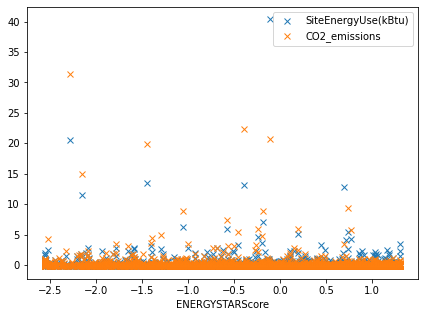

In [56]:
tmp = data[["ENERGYSTARScore", "SiteEnergyUse(kBtu)","CO2_emissions"]].copy()
# tmp = tmp.sort_values("ENERGYSTARScore")
my_std = preprocessing.StandardScaler()
tmp = pd.DataFrame(my_std.fit_transform(tmp),index=tmp.index, columns=tmp.columns)

plt.figure(figsize=(7,5))
plt.plot(tmp["ENERGYSTARScore"],tmp[["SiteEnergyUse(kBtu)","CO2_emissions"]],"x")
plt.legend(["SiteEnergyUse(kBtu)","CO2_emissions"])
plt.xlabel("ENERGYSTARScore")
plt.show()

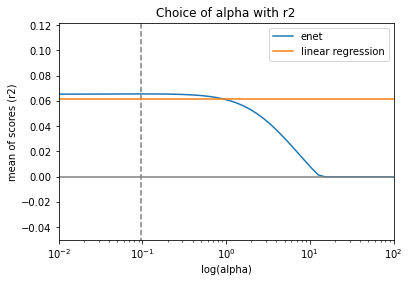

enet  : 


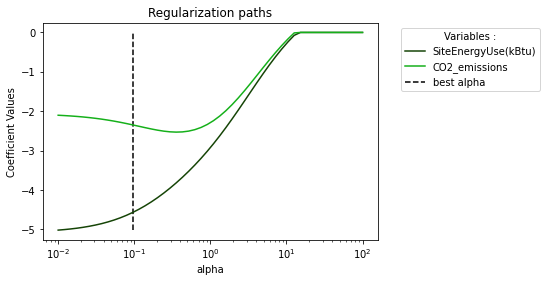

score execution_time best_alpha
lr     0.06174       0.002935       None
enet  0.042344       0.131412    0.09541

In [57]:

# y = data["CO2_emissions"]
# X = data[num_training_var]

y = data_log_transfo["ENERGYSTARScore"]
X = data_log_transfo[["SiteEnergyUse(kBtu)","CO2_emissions"]]
# X = data_log_transfo[np.concatenate((num_training_var,["SiteEnergyUse(kBtu)","CO2_emissions"]))]

# CV for LR init
# alpha_values =  np.logspace(-2, 2, 50)
dict_lr_model= {#"ridge" : linear_model.Ridge(), "lasso" : linear_model.Lasso(),
                "enet" : linear_model.ElasticNet()}
score_name = "r2"
# plot parameters
figsize = (8,5)
fig_name = None ## change to save plot

compute_LR_CV(X, y, dict_lr_model, {"enet":np.logspace(-2, 2, 50)}, score_name, fig_name)

In [58]:
# for var in cat_training_var :
#     plt.figure(figsize=(9,4))
#     plot_boxplot(data_log_transfo, var, "ENERGYSTARScore",sort=True)
#     eta2 = eta_squared(x=data_log_transfo[var], y=data["ENERGYSTARScore"])
#     print(var, ": eta² =",np.round(eta2,2))
#     plt.show()

# Extraction de la table de travail 

## Vectorisation des variables catégorielles 

Il va donc falloir tokentiser les 3 variables catégorielles ('BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseType')

In [59]:
for var in cat_training_var :
    print(var, " : ", len(data[var].cat.categories)," catégories différentes")

BuildingType  :  8  catégories différentes
PrimaryPropertyType  :  26  catégories différentes
Neighborhood  :  13  catégories différentes
LargestPropertyUseType  :  57  catégories différentes


#### Clustering des modalités avec COP-KMeans

Ces variables ont un très grand nombre de catégories différentes, il me semble pertinent de chercher à regrouper ces catégories (selon la variable de sortie) avant de les vectoriser, afin d'éviter le fléau de la dimension. 

J'ai utilisé l'implémentation de COP-Kmeans proposée [sur ce github](https://github.com/Behrouz-Babaki/COP-Kmeans) et la fonction qui calcule le BIC a été extraite de [ce site](https://stats.stackexchange.com/questions/90769/using-bic-to-estimate-the-number-of-k-in-kmeans)

A noter : le résultat du code suivant ne devrait être lancé que dans le second notebook, sur l'ensemble d'apprentissage, pour éviter de surapprendre en faisant cette opération. Néansmoins, comme cela reste un pre-traitement, je présente la démarche ici.

##TODO : lancer ce code sur l'ensemble d'apprentissage plutôt qu'ici.

In [60]:
from copkmeans.cop_kmeans import cop_kmeans

## pour cette partie, je prends les log-transform des variables de sortie, que je renormalise
my_data = df_log_transform(data_non_resid,["SiteEnergyUse(kBtu)","CO2_emissions"])
num_data = my_data.loc[:, ~(my_data.dtypes == "category")]
num_data_std = pd.DataFrame(StandardScaler().fit_transform(num_data),
                      columns = num_data.columns, index = num_data.index)
my_data.at[:, ~(my_data.dtypes == "category")] = num_data_std
my_data = my_data.reset_index()

In [61]:
## very long to run : save res in files
# list_of_cat_var = cat_training_var
# loop_on_cat_var_cluster_category(data_log_tran£sfo, num_vars, list_of_cat_var)

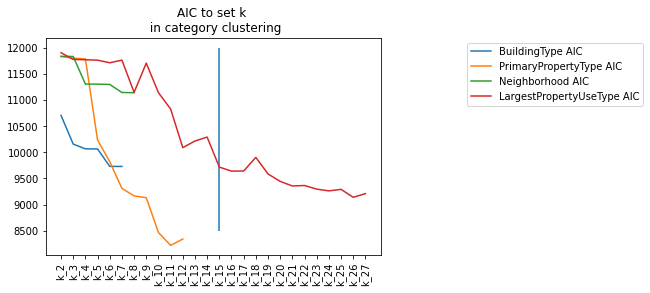

In [62]:
num_vars = ["SiteEnergyUse(kBtu)","CO2_emissions"]

list_of_cat_var = cat_training_var#[cat_training_var[0]]
my_legend = []
for cat_var in list_of_cat_var : 
    cluster_criterion = pd.read_csv(res_path+"set_k_cluster_category_"+ cat_var +".csv",
                                    index_col=0)["AIC"]
    plt.plot(cluster_criterion)
    my_legend = np.concatenate((my_legend,[cat_var+" AIC"]))
plt.xticks(rotation='vertical')
plt.legend(my_legend,loc = "upper right",bbox_to_anchor=(1.8, 1))
plt.title("AIC to set k \n in category clustering")

plt.vlines("k_15",ymin=8500,ymax = 12000)

This setting allowed me to set the better number of cluster for each categorical variable :

In [63]:
dict_best_k_category = { "BuildingType" : 5,
                         "PrimaryPropertyType" : 11,
                         "Neighborhood": 4,
                         "LargestPropertyUseType" : 15}

## construct df with clustering results :
res_cluster = my_data[num_vars].copy()
for cat_var in cat_training_var :
    x = my_data[cat_var]
    must_link = get_must_link(my_data[cat_var])
    k = dict_best_k_category[cat_var]
#     clusters, centers = cluster_categories(x,res_cluster[num_vars], k=k, must_link = must_link)
    ##hack to solve if one dimensionnal Y : 
    Y = pd.concat([res_cluster["SiteEnergyUse(kBtu)"],res_cluster["SiteEnergyUse(kBtu)"]], axis =1)#num_vars
    clusters, centers = cluster_categories(x,Y, k=k, must_link = must_link)
    res_cluster.at[:,cat_var] = clusters
    res_cluster[cat_var] = res_cluster[cat_var].astype("category")
    

In [64]:
## change modalities in category if there is only one in cluster 
## + extract dictionary of correspondance cluster/variables
dict_corresp_cluster = {}

res_cluster2 = res_cluster.copy()
for cat_var in cat_training_var :
    original = my_data[cat_var]
    cluster = res_cluster2[cat_var]
    dict_rename_cat = {}
    dict_corresp_cluster_var = get_corresp_cluster_var(original, cluster)
    for clust_k, modalities in dict_corresp_cluster_var.items() :
        if len(modalities)==1:
            dict_rename_cat[clust_k] = modalities[0]
        dict_corresp_cluster[cat_var+"_"+str(clust_k)] = modalities
    #         res_cluster.at[res_cluster[cat_var]==clust_k,cat_var] = modalities[0]
    res_cluster2[cat_var] = res_cluster2[cat_var].cat.rename_categories(dict_rename_cat)
# dict_corresp_cluster

BuildingType original : eta² = 0.035
BuildingType clustered : eta² = 0.035


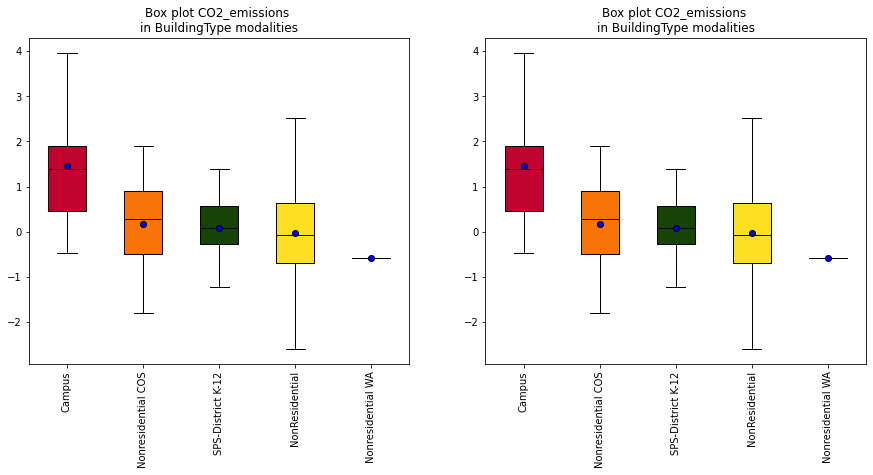

PrimaryPropertyType original : eta² = 0.321
PrimaryPropertyType clustered : eta² = 0.238


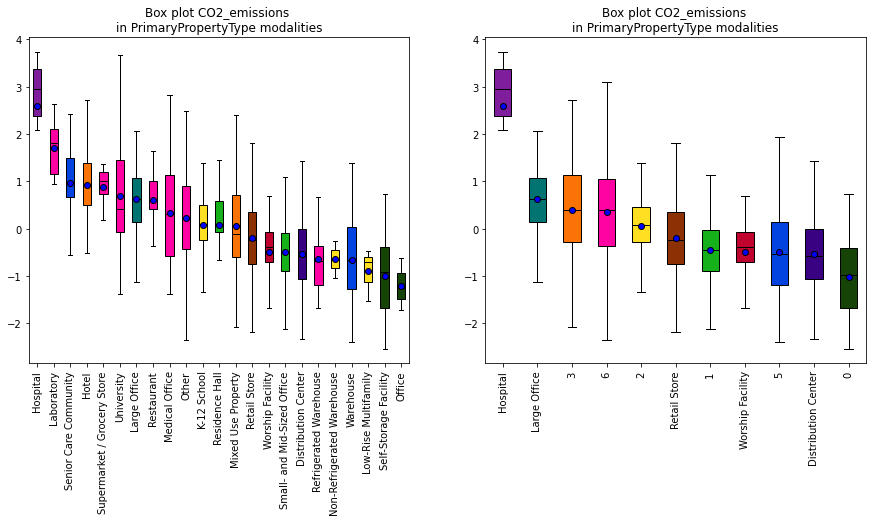

Neighborhood original : eta² = 0.055
Neighborhood clustered : eta² = 0.02


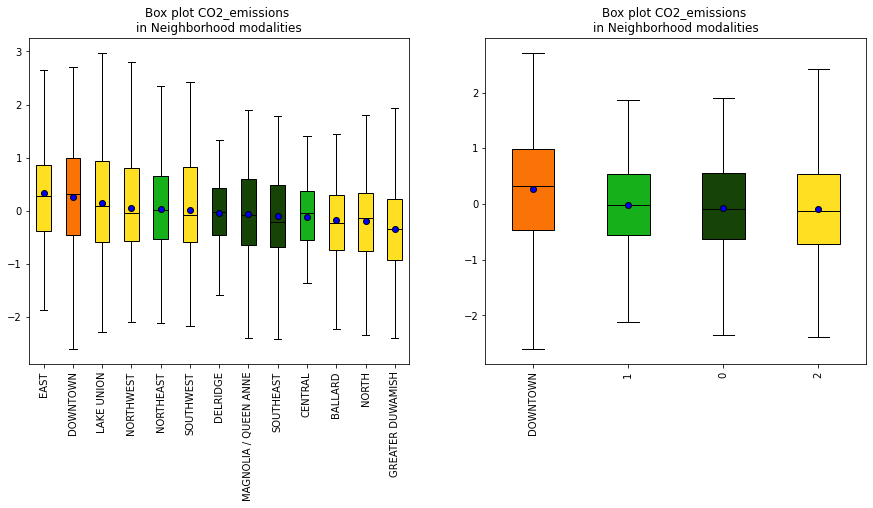

LargestPropertyUseType original : eta² = 0.274
LargestPropertyUseType clustered : eta² = 0.207


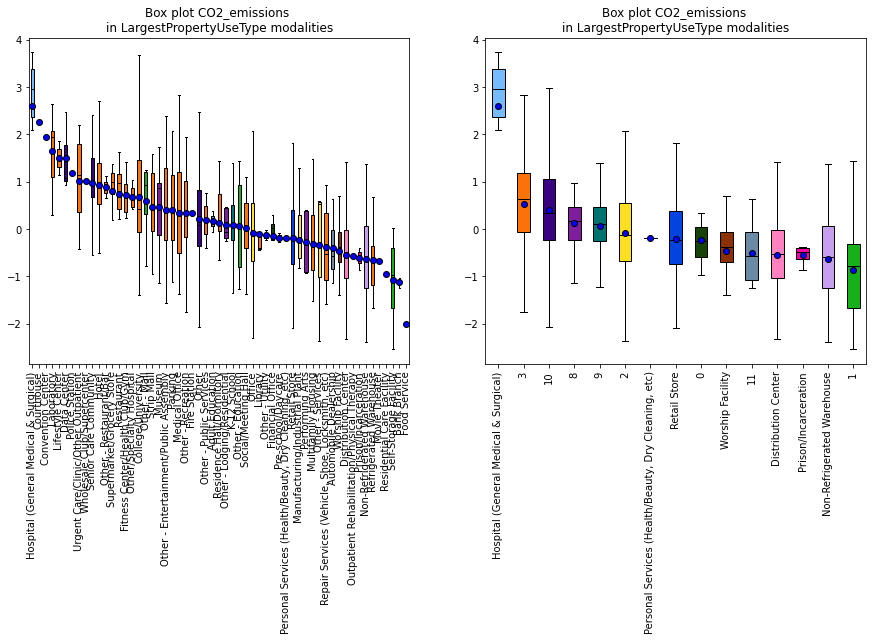

In [65]:
figsize = (15,6)
num_var = "CO2_emissions"
for cat_var in cat_training_var :
    compare_boxplots_clustered_category_COPkmeans(res_cluster2, my_data,  
                                    cat_var, num_var, figsize =figsize)
    plt.show()

BuildingType original : eta² = 0.031
BuildingType clustered : eta² = 0.031


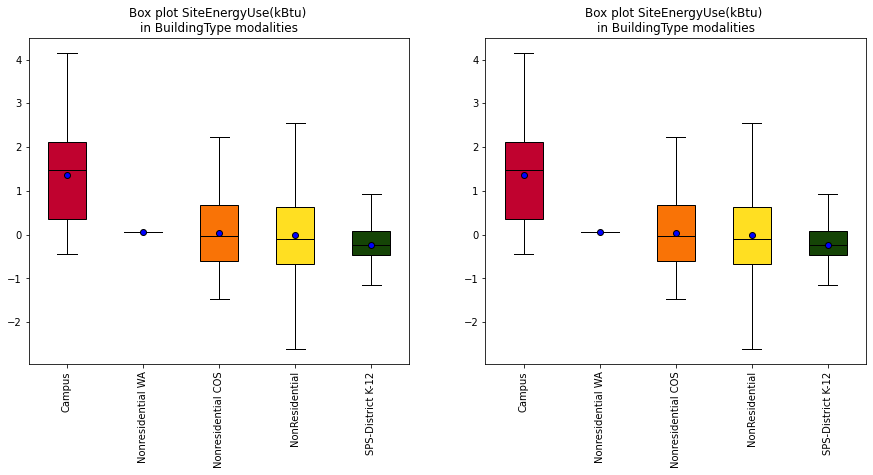

PrimaryPropertyType original : eta² = 0.372
PrimaryPropertyType clustered : eta² = 0.316


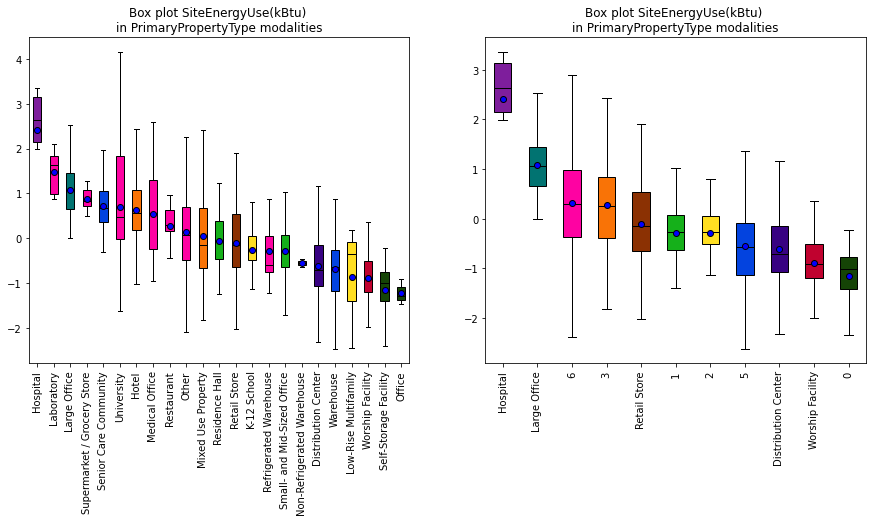

Neighborhood original : eta² = 0.084
Neighborhood clustered : eta² = 0.045


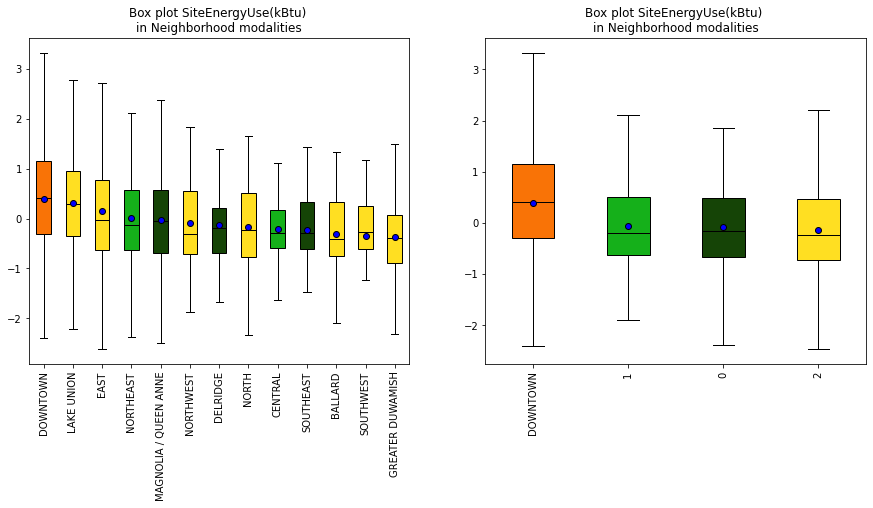

LargestPropertyUseType original : eta² = 0.293
LargestPropertyUseType clustered : eta² = 0.231


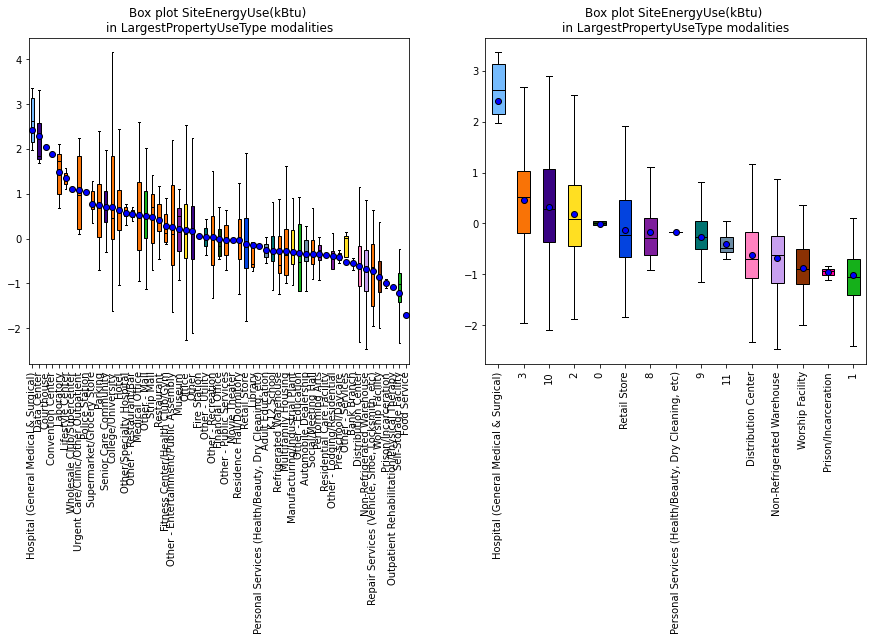

In [66]:
figsize = (15,6)
num_var = "SiteEnergyUse(kBtu)"
for cat_var in cat_training_var :
    compare_boxplots_clustered_category_COPkmeans(res_cluster2, my_data,  
                                    cat_var, num_var, figsize =figsize)
    dict_corresp_cluster_var = get_corresp_cluster_var(my_data[cat_var], res_cluster[cat_var])
#     print(dict_corresp_cluster_var)
    plt.show()

#### Clustering des modalités à la main :
pour faciliter la lecture des groupes à la main : 

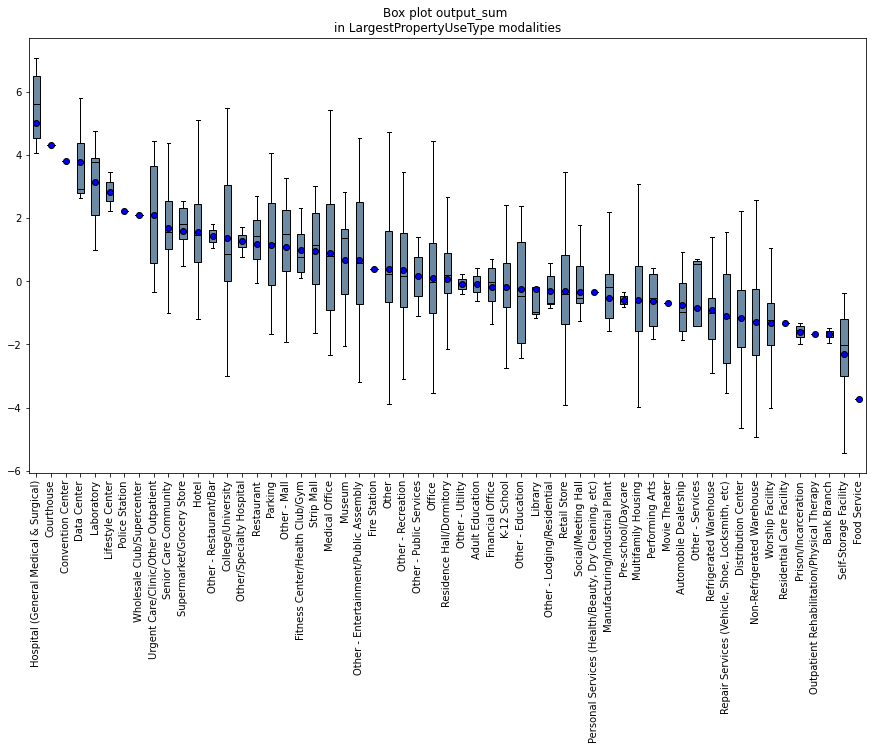

In [69]:
cat_var = "LargestPropertyUseType"

plt.figure(figsize=(15,8))
output_std_sum = my_data[["SiteEnergyUse(kBtu)","CO2_emissions"]].sum(axis = 1)#pd.DataFrame(StandardScaler().fit_transform(data_non_resid[num_vars]))
# output_std_sum = np.log(output_std_sum.sum(axis=1)+1)
output_std_sum = output_std_sum.rename("output_sum")
tmp = pd.concat((output_std_sum ,my_data[cat_var]),axis =1)
## print sorted modalities 
tmp[cat_var] = tmp[cat_var].cat.remove_unused_categories()
groups, modalities, sort_index = sort_by_modality_mean(tmp,cat_var, "output_sum",True)  
# print(modalities)

plot_boxplot(tmp, cat_var, "output_sum",sort=True)
plt.show()
# my_data["LargestPropertyUseType"].cat.categories

In [77]:
from preprocess import *

cat_training_var = list(dict_cluster.keys())

res_cluster = my_data[np.concatenate((cat_training_var,["SiteEnergyUse(kBtu)","CO2_emissions"]))].copy()
for var in cat_training_var :
    cluster_var = dict_cluster[var]

    tmp = pd.Series(index = res_cluster.index, dtype = "category", name=var)
    tmp = tmp.cat.set_categories(cluster_var.keys())
    for cluster, list_categories in cluster_var.items():
        for category in list_categories:
            category_index = res_cluster[res_cluster[var] == category].index
            tmp[category_index] = cluster
    res_cluster = res_cluster.drop(var, axis = 1)
    res_cluster = pd.concat((res_cluster,tmp), axis = 1)


In [78]:
dict_cluster["LargestPropertyUseType"] = {
                        "hospital":['Hospital (General Medical & Surgical)'],
                        "gathering":['Courthouse', 'Data Center','Convention Center',],
                        "cares/university":['Laboratory', 'Lifestyle Center',
                            'Urgent Care/Clinic/Other Outpatient'],
                        "university":['College/University'],
                        "1":[ 'Police Station', 'Wholesale Club/Supercenter'],
                        "service":['Senior Care Community', 'Hotel', 'Supermarket/Grocery Store',
                            'Other - Mall', 'Parking','Medical Office',
                            'Other - Entertainment/Public Assembly', 'Other - Restaurant/Bar',
                            'Strip Mall', 'Restaurant',],
                        "2":['Other/Specialty Hospital', 'Museum', 'Other',
       'Fitness Center/Health Club/Gym', 'Other - Recreation', ],
                        "3":['Office',
       'Other - Education', 'Residence Hall/Dormitory',
       'Other - Public Services',],
                        "4":['Fire Station', 'Retail Store', 'Library',
       'K-12 School', 'Multifamily Housing', 'Manufacturing/Industrial Plant',
       'Financial Office', 'Social/Meeting Hall', ],
                        "5":['Other - Utility',
       'Adult Education', 'Other - Services', 'Other - Lodging/Residential',],
                        "6":['Refrigerated Warehouse',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Performing Arts',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',],
                        "7":['Automobile Dealership', 'Movie Theater', 'Distribution Center',
       'Pre-school/Daycare', 'Non-Refrigerated Warehouse', 'Worship Facility',
       'Residential Care Facility',],
                        "8":['Bank Branch', 'Prison/Incarceration',
       'Outpatient Rehabilitation/Physical Therapy', 'Self-Storage Facility',],
                        "9":['Food Service'], }

LargestPropertyUseType original : eta² = 0.293


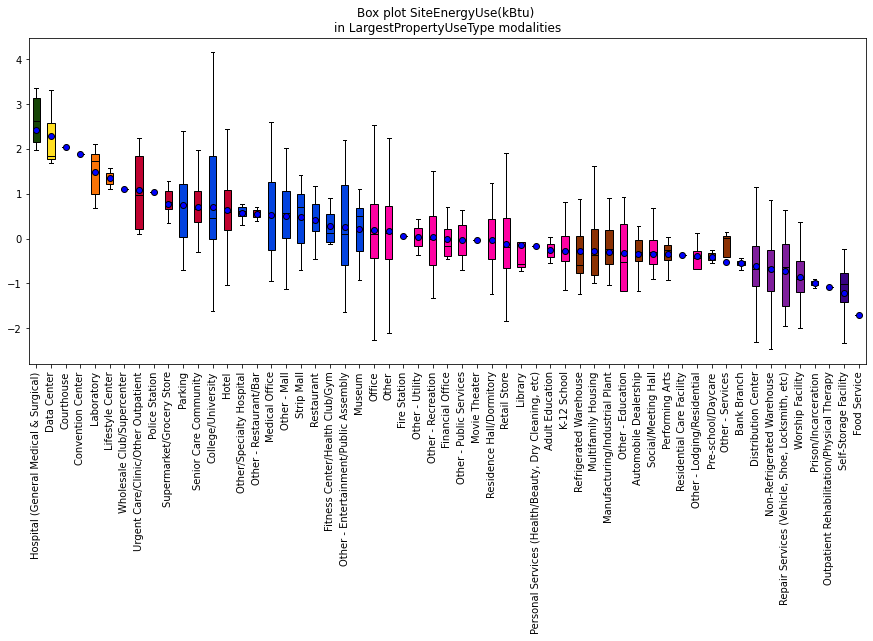

LargestPropertyUseType original : eta² = 0.268


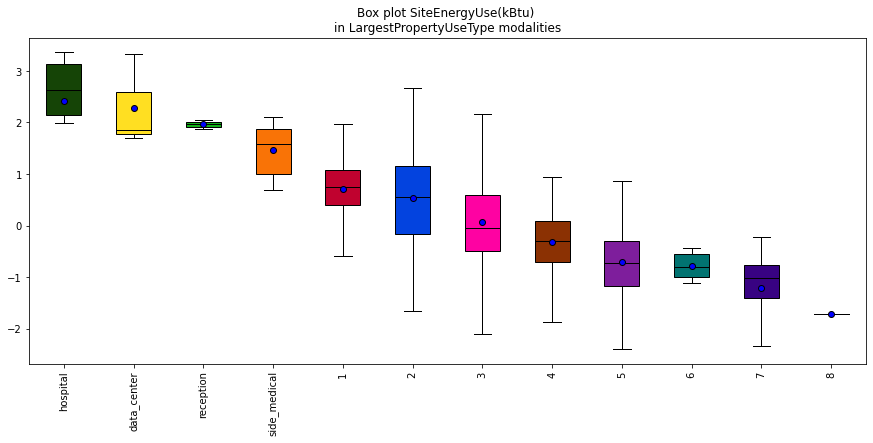

LargestPropertyUseType original : eta² = 0.274


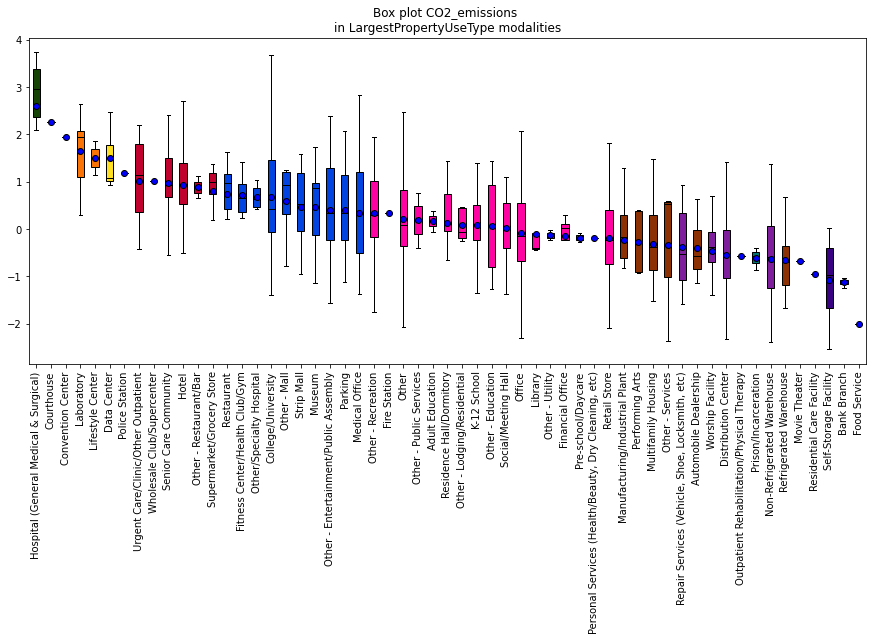

LargestPropertyUseType original : eta² = 0.259


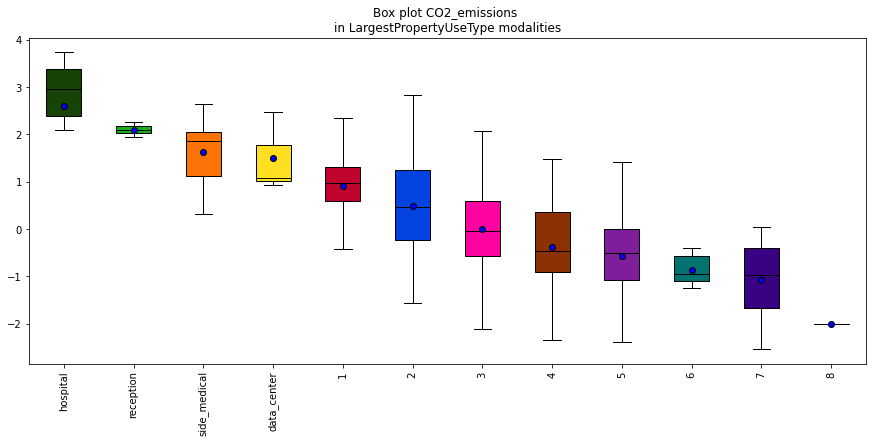

In [79]:
cat_var = "LargestPropertyUseType"

fig_size = (15,6)
for num_var in ["SiteEnergyUse(kBtu)","CO2_emissions"]:
    original = my_data[cat_var]
    cluster = res_cluster[cat_var]
    ## get colors : 
    dict_color_mod = get_different_clustering_color(original,cluster)
    
    plt.figure(figsize=fig_size)
    plot_boxplot(my_data, cat_var, num_var,sort=True, dict_color_mod = dict_color_mod)
    eta2 = eta_squared(x=my_data[cat_var], y=my_data[num_var])
    print(cat_var, "original : eta² =",np.round(eta2,3))
    plt.show()
    
    plt.figure(figsize=fig_size)
    plot_boxplot(res_cluster,cat_var, num_var, sort=True, dict_color_mod = dict_color_mod)
    eta2 = eta_squared(x=res_cluster[cat_var], y=res_cluster[num_var])
    print(cat_var, "original : eta² =",np.round(eta2,3))
    plt.show()

BuildingType original : eta² = 0.031
BuildingType clustered : eta² = 0.028


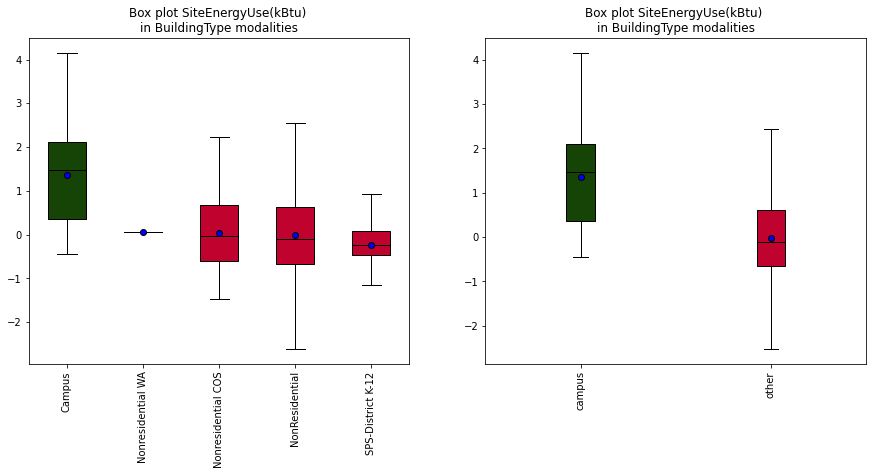

PrimaryPropertyType original : eta² = 0.372
PrimaryPropertyType clustered : eta² = 0.348


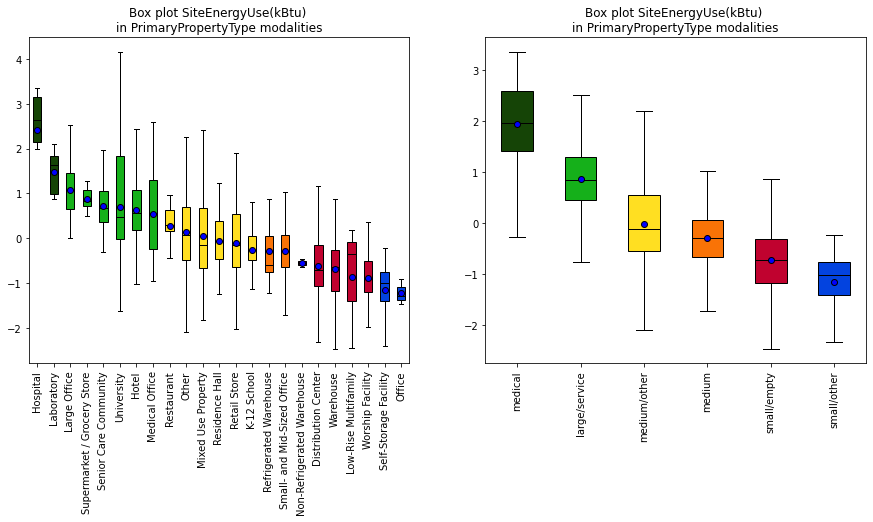

LargestPropertyUseType original : eta² = 0.293
LargestPropertyUseType clustered : eta² = 0.268


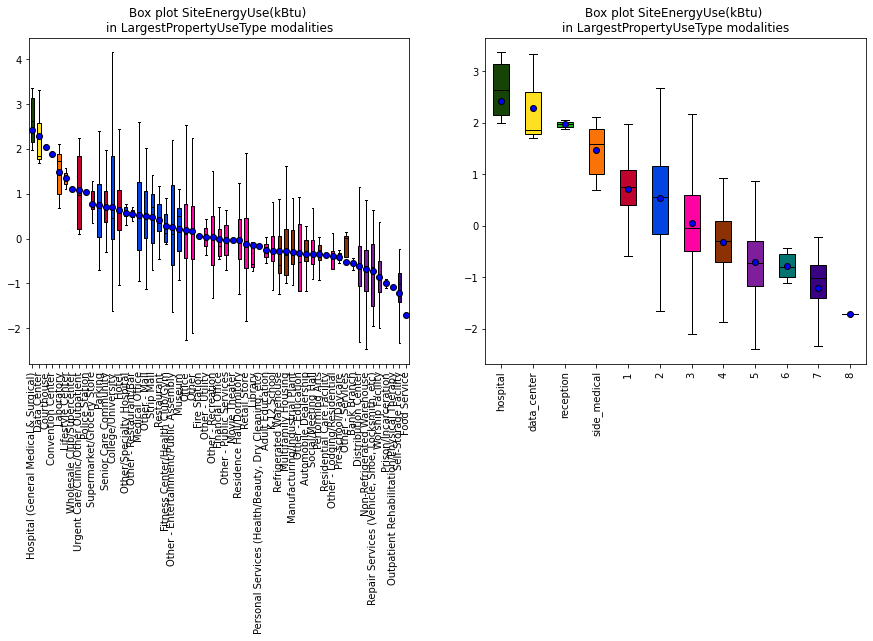

BuildingType original : eta² = 0.035
BuildingType clustered : eta² = 0.032


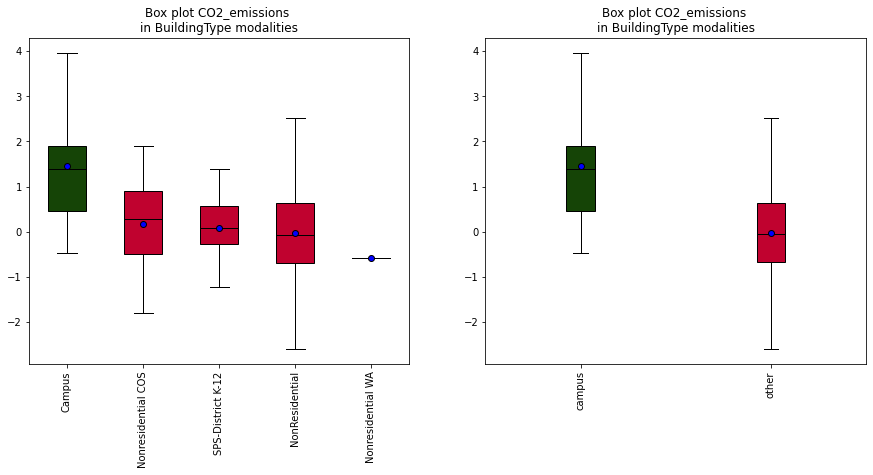

PrimaryPropertyType original : eta² = 0.321
PrimaryPropertyType clustered : eta² = 0.3


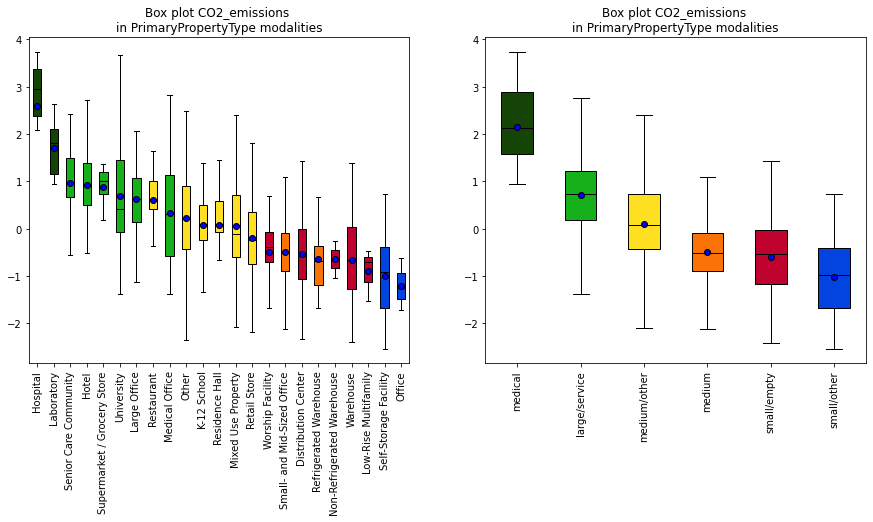

LargestPropertyUseType original : eta² = 0.274
LargestPropertyUseType clustered : eta² = 0.259


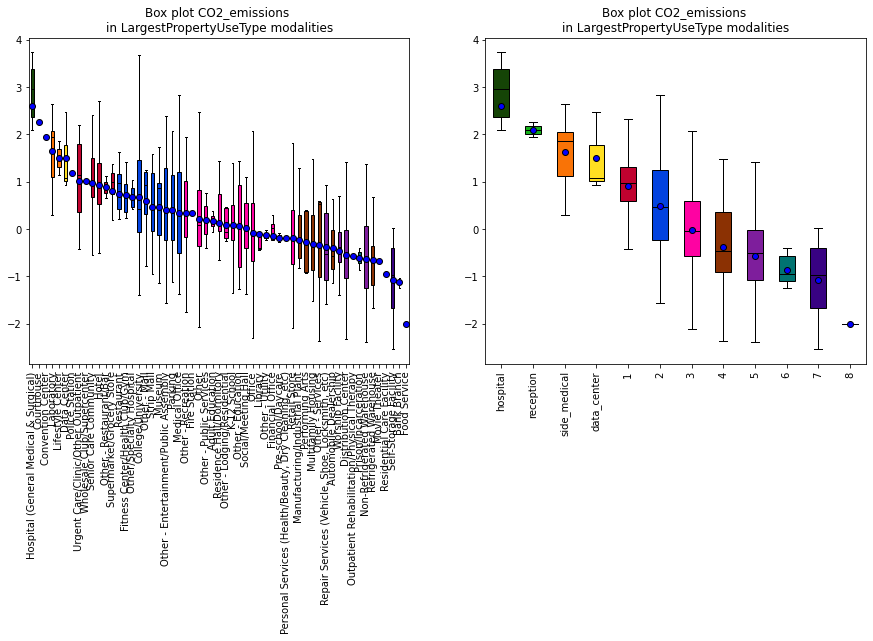

In [80]:
num_var = "SiteEnergyUse(kBtu)"
for cat_var in  cat_training_var:
    compare_boxplots_clustered_category_COPkmeans(res_cluster, my_data,  
                                    cat_var, num_var, figsize =figsize)
    plt.show()

num_var = "CO2_emissions"
for cat_var in cat_training_var :
    compare_boxplots_clustered_category_COPkmeans(res_cluster, my_data,  
                                    cat_var, num_var, figsize =figsize)
    plt.show()

## WORK IN PROCESS ... 
Ce travail n'est pas fini (attente ref/ aller en chercher, faire le travail de dev sur l'échantillon  d'entrainement ...) Le clustering automatique des modalités n'est pas très satisfaisant, puisqu'il regroupe des groupes avec des moyennes assez différentes (pas à côté dans le boxplot). 

En attendant, j'ai vectorisé ces modalités regroupées à la main, pour les variables "BuildingType" et "PrimaryPropertyType", pour passer à la suite. Pour faire mieux, je verrai plus tard, si j'en ai le temps.

nb : Le traitement à la main pour "LargestPropertyUseType" était fastidieux, et la variable a l'air de faire doublon avec "PrimaryPropertyType", et représente moins bien la structure des variables de réponse -> a voir si on garde. 

In [81]:
## plusieurs methodes possibles via sklearn, ex : 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## data avec var de rep et num_train

selected_var = np.concatenate((num_training_var,["SiteEnergyUse(kBtu)","CO2_emissions","ENERGYSTARScore"]))
new_data = data_non_resid[data_non_resid.columns.intersection(selected_var)].copy()

## j'utilise la methode de pandas : 
for cat_var in cat_training_var : 
    cat_data = pd.get_dummies(res_cluster[cat_var])
    cat_data = cat_data.add_prefix(cat_var+"_")
    new_data = new_data.merge(cat_data, left_index=True, right_index=True)

In [82]:
new_data.to_csv(res_path+"cleanned_data.csv")
new_data = pd.read_csv(res_path+"cleanned_data.csv", index_col=0)
new_data

ZipCode  NumberofFloors  PropertyGFAParking  LargestPropertyUseTypeGFA  \
0     98101.0            12.0                 0.0                    88434.0   
1     98101.0            11.0             15064.0                    83880.0   
2     98101.0            41.0             98359.0                   756868.0   
3     98101.0            10.0                 0.0                    61320.0   
4     98121.0            18.0             37230.0                   123445.0   
...       ...             ...                 ...                        ...   
1678  98144.0             1.0                 0.0                    21603.0   
1690  98112.0             3.0                 0.0                   520187.0   
1691  98108.0             1.0                 0.0                    43050.0   
1692  98108.0             1.0                 0.0                    57952.0   
1693  98108.0             1.0                 0.0                    18262.0   

      ENERGYSTARScore  SiteEnergyUse(kBtu)  CO2_emissions  age_of_building  \
0              62.500         7.103895e+06        249.705             88.5   
1              56.000         8.371084e+06        279.685             19.5   
2              30.500         7.285884e+07       2075.380             46.5   
3              28.500         1.751195e+07       1111.385             89.5   
4              71.000         1.450085e+07        506.355             35.5   
...               ...                  ...            ...              ...   
1678           16.000         5.820840e+06        124.730             50.5   
1690           60.500         1.038255e+08       3279.630             51.5   
1691           56.500         4.134892e+05          2.880             36.5   
1692           74.875         3.098194e+06         94.810             10.5   
1693           47.250         2.984136e+06        117.420             44.5   

      SPD Beats  BuildingType_campus  ...  LargestPropertyUseType_data_center  \
0          31.0                    0  ...                                   0   
1          31.0                    0  ...                                   0   
2          31.0                    0  ...                                   0   
3          31.0                    0  ...                                   0   
4          31.0                    0  ...                                   0   
...         ...                  ...  ...                                 ...   
1678       41.0                    0  ...                                   0   
1690        4.0                    0  ...                                   0   
1691       15.0                    0  ...                                   0   
1692       15.0                    0  ...                                   0   
1693       15.0                    0  ...                                   0   

      LargestPropertyUseType_side_medical  LargestPropertyUseType_1  \
0                                       0                         1   
1                                       0                         1   
2                                       0                         1   
3                                       0                         1   
4                                       0                         1   
...                                   ...                       ...   
1678                                    0                         0   
1690                                    0                         0   
1691                                    0                         0   
1692                                    0                         0   
1693                                    0                         0   

      LargestPropertyUseType_2  LargestPropertyUseType_3  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0            

# Pistes d'amélioration :



* une methode de clustering des catégories plus efficace
* J'ai utilisé les données sur les batiments résidentiels pour l'imputation de données manquantes -> ce n'est pas clair qu'ils fassent partie de l'étude. Donc 1) attention si biais + pas sur de les avoir
